In [1]:
# import our standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.model_selection import train_test_split
import seaborn as sns
from pandas.core.common import SettingWithCopyWarning
import warnings
import json
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)

In [2]:
# import other tools and models
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, FunctionTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_predict
from sklearn.metrics import r2_score, confusion_matrix, f1_score, make_scorer, recall_score, classification_report, accuracy_score
from scipy.stats import pearsonr, normaltest
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.base import BaseEstimator, TransformerMixin

In [3]:
# use everywhere:
plt.style.use('seaborn-dark')

In [4]:
# load and verify the dataset
dataset_path = 'healthcare-dataset-stroke-data.csv'

df = pd.read_csv(dataset_path)

df.head()


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [5]:
df.columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

# Data Exploration

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
id                   5110 non-null int64
gender               5110 non-null object
age                  5110 non-null float64
hypertension         5110 non-null int64
heart_disease        5110 non-null int64
ever_married         5110 non-null object
work_type            5110 non-null object
Residence_type       5110 non-null object
avg_glucose_level    5110 non-null float64
bmi                  4909 non-null float64
smoking_status       5110 non-null object
stroke               5110 non-null int64
dtypes: float64(3), int64(4), object(5)
memory usage: 479.1+ KB


In [6]:
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [7]:
# print out the unique values in each category
print(df['hypertension'].unique())
print(df['heart_disease'].unique())
print(df['ever_married'].unique())
print(df['work_type'].unique())
print(df['Residence_type'].unique())
print(df['smoking_status'].unique())
print(df['stroke'].unique())

[0 1]
[1 0]
['Yes' 'No']
['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
['Urban' 'Rural']
['formerly smoked' 'never smoked' 'smokes' 'Unknown']
[1 0]


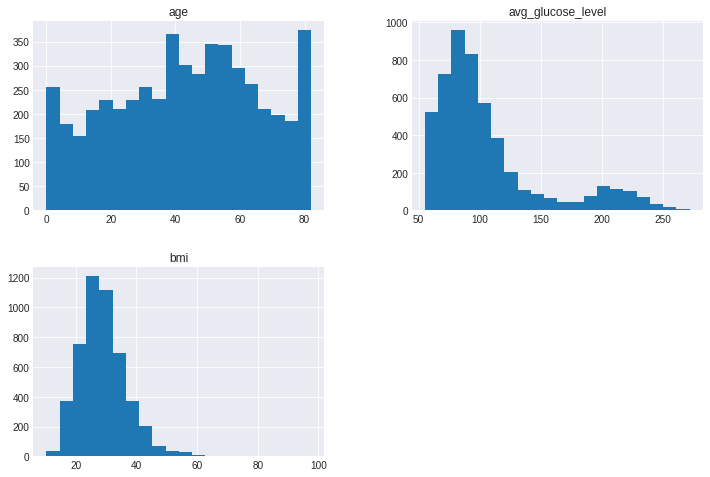

In [8]:
# tried 10, 20, 30, 40 bins, 20 is a good visualisation of the distribution of the data
df[['age', 'avg_glucose_level', 'bmi']].hist(bins=20, figsize=(12,8))
plt.show()

Test the normality of the distributions using D'Agostino's K^2 Test. Shapiro-Wilk does not suit the size of the data while D'Agostino's checks skewness and kurtosis.

In [9]:
# make age numpy array
age_np = np.array(df['age'])

# D'Agostino's K^2 Test
dagostino_test = normaltest(age_np)
print(f"Age D'Agostino's K^2 Test: Statistics={dagostino_test.statistic}, p-value={dagostino_test.pvalue}")


# make avg_glucose_level numpy array
avg_glucose_level_np = np.array(df['avg_glucose_level'])

# D'Agostino's K^2 Test
dagostino_test = normaltest(avg_glucose_level_np)
print(f"Glucose D'Agostino's K^2 Test: Statistics={dagostino_test.statistic}, p-value={dagostino_test.pvalue}")


# make bmi numpy array
bmi_np = np.array(df['bmi'].dropna())

# D'Agostino's K^2 Test
dagostino_test = normaltest(bmi_np)
print(f"BMI D'Agostino's K^2 Test: Statistics={dagostino_test.statistic}, p-value={dagostino_test.pvalue}")

Age D'Agostino's K^2 Test: Statistics=1120.5286442208073, p-value=4.7895697274981233e-244
Glucose D'Agostino's K^2 Test: Statistics=1328.9357947091423, p-value=2.662310941715711e-289
BMI D'Agostino's K^2 Test: Statistics=1021.1795052962864, p-value=1.793444363882936e-222


For Age, BMI, and Glucose Level, all distributions deviate from a normal distribut as the results all return a p-value < 0.01. For Age, this is not a problem with the multi-modal nature of the data, but for avg_glucose_leve and bmi this highlights the need for transformations in the data during our preprocessing steps.

In [10]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


# Data Understanding

id - the unique id of the patient
gender - male, female or other gender of patient - nominal
age - Discrete age value of the patient
hypertension - nominal boolean indicating whether the patient suffered from hypertension or not
heart_disease - nominal boolean indicating whether the patient suffered from heart disease or not
ever_married - nominal boolean indicating whether the patient was ever married or not
work_type - nominal categorical values indicating the type of work the patient did
Residence_type - nominal boolean values indicating the living area of the patient
avg_glucose_level - continuous value indicating the average glucose level found in the patient's blood
bmi - continuous value indicating the patient's body mass index value
smoking_status - nominal value indicating whether a patient, does or has ever smoked

## Notes
- From Describe, we can see that BMI has missing values
- Minimum value of 'age' is not a discrete number, we need to check for outliers
- For bmi there is a right skew to the distribution indicating that we will need to transform it using a log algorithm, other values show a acceptable distribution
- Considering 'age', we may look at binning/categorising the data after some exploratory analysis
- Noted class imbalance of the target variable 'stroke'


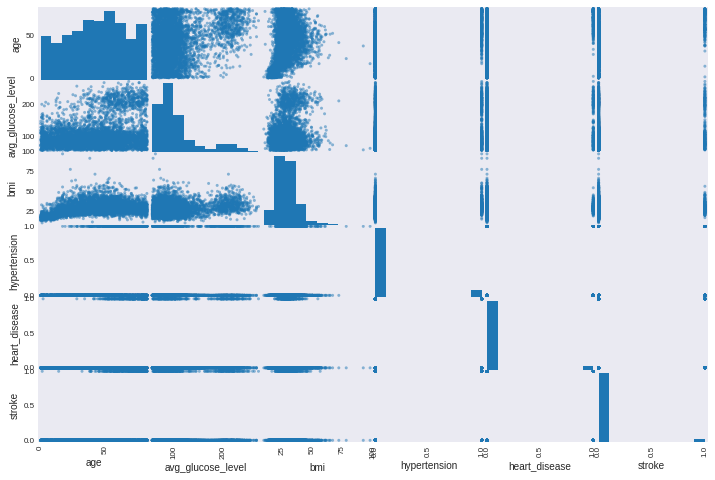

In [11]:
pd.plotting.scatter_matrix(df[['age', 'avg_glucose_level', 'bmi', 'hypertension', 'heart_disease', 'stroke']], figsize=(12,8))
plt.show()

The above matrix shows some interesting relationships. BMI follows a logical arced pattern as age increases, which we can completely understand as something which naturally happens to the human body. Increased glucose level, the right skewed part of the distribution, seems to be correlated with age to a degree, we should explore this further. An interesting view is the relationship between age and the target variable, the number of strokes that occur in lower ages is minimal, while after a certain age it increases, this indicates that any modelling we do could be served better by using classifications with age.

## Exploring Correlations

Starting with age, we will work through the correlations and explore more deeply what the correlations are like which were represented above

### Age and Average Glucose Level

Assess the correlation and visualise it by building a simple regression model, plot the relationship, and measure it by correlation coefficient/R^2 value

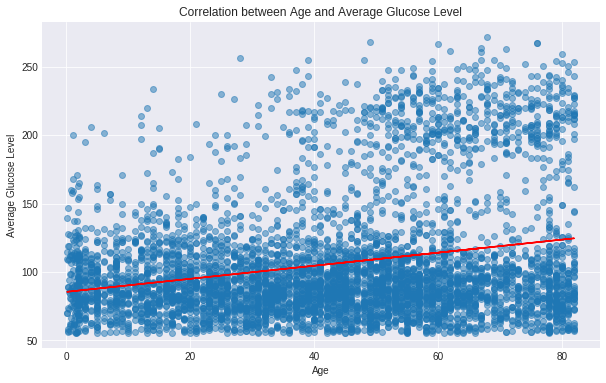

Correlation coefficient: 0.23817111410174327
P-value: 7.856310807798251e-67
R-squared for Linear Regression: 0.05672547959246543


In [12]:
# Prepare the data for linear regression
X = df['age'].values.reshape(-1, 1)  # Reshaping for sklearn compatibility
y = df['avg_glucose_level'].values

# Fit the linear regression model
model = LinearRegression()
model.fit(X, y)

# Make predictions
y_pred = model.predict(X)

# Plotting the scatter plot and the linear regression line
plt.figure(figsize=(10, 6))
plt.scatter(df['age'], df['avg_glucose_level'], alpha=0.5)
plt.plot(df['age'], y_pred, color='red')  # This is the line of best fit
plt.title('Correlation between Age and Average Glucose Level')
plt.xlabel('Age')
plt.ylabel('Average Glucose Level')
plt.grid(True)
plt.show()


# print the correlation coefficient, p-value, and rsquared value
r2 = r2_score(y, y_pred)
correlation, p_value = pearsonr(df['age'], df['avg_glucose_level'])
print(f"Correlation coefficient: {correlation}")
print(f"P-value: {p_value}")
print(f"R-squared for Linear Regression: {r2}")


The correlation coefficient is 0.24 indicating a weak, linear, positive relationship.

The P-value < 0.01 suggests this result is statistically significant and that the correlation accurately depicts the relationship, while not implying causation due to the weak correlation coefficient.

We would like to check if the relationship is non linear by using a polynomial regression.

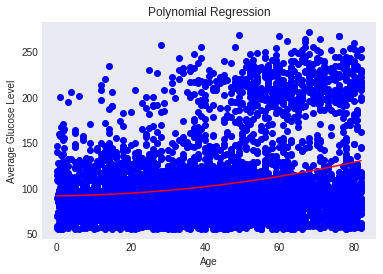

R-squared for Polynomial Regression: 0.06012483585694728


In [13]:
# to plot the line of best fit in a non linear relationship we need to fit a model to the data and use its predictions in order to visualise the line.
X = df['age'].values.reshape(-1, 1)
y = df['avg_glucose_level'].values

# Polynomial Regression - Degree 2
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)
poly_reg_model = LinearRegression()
poly_reg_model.fit(X_poly, y)

# Predictions
y_pred = poly_reg_model.predict(X_poly)

# Sort the values of X and y_pred for plotting
sorted_indices = X.flatten().argsort()
X_sorted = X.flatten()[sorted_indices]
y_pred_sorted = y_pred[sorted_indices]

# Plotting
plt.scatter(X, y, color='blue')
plt.plot(X_sorted, y_pred_sorted, color='red')  # Sorted values for a smooth curve
plt.title('Polynomial Regression')
plt.xlabel('Age')
plt.ylabel('Average Glucose Level')
plt.show()

# Calculate R-squared
r2 = r2_score(y, y_pred)
print(f"R-squared for Polynomial Regression: {r2}")


The low R-squared value of 0.06 indicates that age is a low explanation for the variation in average glucose level.
This value is also not much different from the linear regression Rsquared value, showing the fit of the data does not vary between the 2 models and the relationship can be described as linear or polynomial without much difference. 

It is not a strong relationship which allows us to assume there is low/no colinearity and the 2 attributes can be used as features together for further modelling.

### Age and BMI

Assess the correlation and visualise it by building a simple regression model, plot the relationship, and measure it by correlation coefficient/R^2 value.

The data rows where bmi is NA/null will be dropped for this assessment.

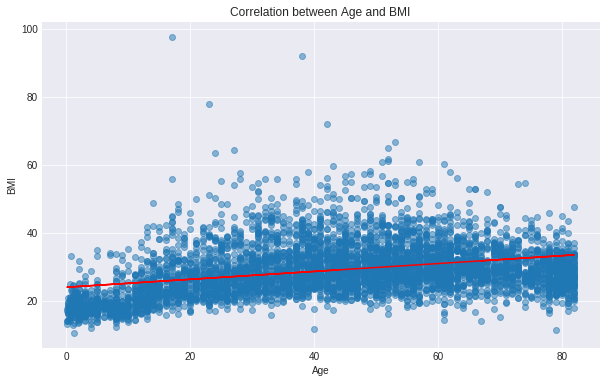

Correlation coefficient: 0.33339799516043944
P-value: 9.515844789950418e-128
R-squared for Linear Regression: 0.11115422317700019


In [14]:
# Prepare the data for linear regression, filter out the null values from selection
df_filtered = df[df['bmi'].notna()]
X = df_filtered['age'].values.reshape(-1, 1)  # Reshaping for sklearn compatibility
y = df_filtered['bmi'].values

# Fit the linear regression model
model = LinearRegression()
model.fit(X, y)

# Make predictions
y_pred = model.predict(X)

# Plotting the scatter plot and the linear regression line
plt.figure(figsize=(10, 6))
plt.scatter(df['age'], df['bmi'], alpha=0.5)
plt.plot(df_filtered['age'], y_pred, color='red')  # This is the line of best fit
plt.title('Correlation between Age and BMI')
plt.xlabel('Age')
plt.ylabel('BMI')
plt.grid(True)
plt.show()


# print the correlation coefficient, p-value, and rsquared value
r2 = r2_score(y, y_pred)
correlation, p_value = pearsonr(df_filtered['age'], df_filtered['bmi'])
print(f"Correlation coefficient: {correlation}")
print(f"P-value: {p_value}")
print(f"R-squared for Linear Regression: {r2}")

There is a positive moderate correlation between age and bmi with a correlation coefficient of 0.33. This is a statistically significant result as the P-value < 0.01.

We would like to check if the relationship is non linear by using a polynomial regression.Visually it looks like there may be a non linear relationship.

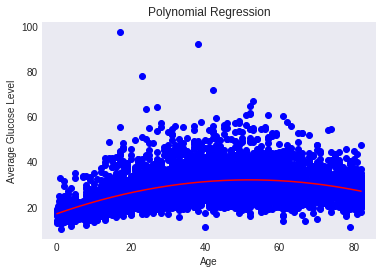

R-squared for Polynomial Regression: 0.2404033209990395


In [15]:
# Prepare the data for polynomial regression, filter out the null values from selection
df_filtered = df[df['bmi'].notna()]
X = df_filtered['age'].values.reshape(-1, 1)  # Reshaping for sklearn compatibility
y = df_filtered['bmi'].values

# Polynomial Regression - Degree 2
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)
poly_reg_model = LinearRegression()
poly_reg_model.fit(X_poly, y)

# Predictions
y_pred = poly_reg_model.predict(X_poly)

# Sort the values of X and y_pred for plotting
sorted_indices = X.flatten().argsort()
X_sorted = X.flatten()[sorted_indices]
y_pred_sorted = y_pred[sorted_indices]

# Plotting
plt.scatter(X, y, color='blue')
plt.plot(X_sorted, y_pred_sorted, color='red')  # Sorted values for a smooth curve
plt.title('Polynomial Regression')
plt.xlabel('Age')
plt.ylabel('Average Glucose Level')
plt.show()

# Calculate R-squared
r2 = r2_score(y, y_pred)
print(f"R-squared for Polynomial Regression: {r2}")

The moderate R-squared value of 0.24 indicates that age explains a fair portion of the variation in bmi. This value is also very different, almost double, from the linear regression Rsquared value, showing the polynomial relationship fits the data more effectively than a purely linear model. Though the relationship is moderate, it is not a strong relationship which allows us to assume there is low colinearity and the 2 attributes can be used as features together for further modelling.

### Average Glucose Level and BMI
Assess the correlation and visualise it by building a simple regression model, plot the relationship, and measure it by correlation coefficient/R^2 value.

In this relationship we need to scale the data before plotting. The data rows where bmi is NA/null will be dropped for this assessment.

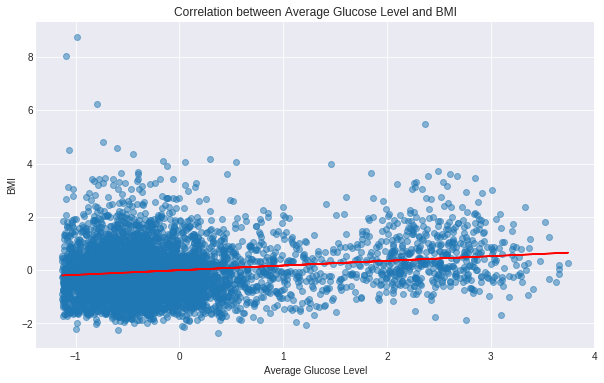

Correlation coefficient: 0.17550217613626068
P-value: 2.9762029034555275e-35
R-squared for Linear Regression: 0.030801013828563262


In [16]:
# Prepare the data for linear regression, filter out the null values from selection
df_filtered = df[df['bmi'].notna()]

# Standard Scaler for X and y
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X = scaler_X.fit_transform(df_filtered['avg_glucose_level'].values.reshape(-1, 1))  # Reshaping and scaling
y = scaler_y.fit_transform(df_filtered['bmi'].values.reshape(-1, 1))

# Fit the linear regression model
model = LinearRegression()
model.fit(X, y)

# Make predictions
y_pred = model.predict(X)

# Plotting the scatter plot and the linear regression line
plt.figure(figsize=(10, 6))
plt.scatter(X, y, alpha=0.5)
plt.plot(X, y_pred, color='red')  # This is the line of best fit
plt.title('Correlation between Average Glucose Level and BMI')
plt.xlabel('Average Glucose Level')
plt.ylabel('BMI')
plt.grid(True)
plt.show()


# print the correlation coefficient, p-value, and rsquared value
r2 = r2_score(y, y_pred)
correlation, p_value = pearsonr(df_filtered['avg_glucose_level'], df_filtered['bmi'])
print(f"Correlation coefficient: {correlation}")
print(f"P-value: {p_value}")
print(f"R-squared for Linear Regression: {r2}")

The correlation coefficient of 0.176 indicates a weak positive relationship, but it is statistically significant, as the p-value < 0.01, therefore we are confident that there is a relationship regardless of how weak that relationship is. A low R-Squared (3.08%) indicates that there are likely to be other factors which influence the dependent variable to a greater extent than the independent variable.

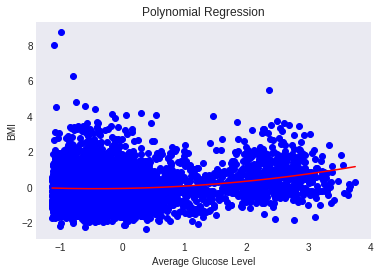

R-squared for Polynomial Regression: 0.03746519340839982


In [17]:
# Prepare the data for linear regression, filter out the null values from selection
df_filtered = df[df['bmi'].notna()]

# Standard Scaler for X and y
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X = scaler_X.fit_transform(df_filtered['avg_glucose_level'].values.reshape(-1, 1))  # Reshaping and scaling
y = scaler_y.fit_transform(df_filtered['bmi'].values.reshape(-1, 1))

# Polynomial Regression - Degree 2
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)
poly_reg_model = LinearRegression()
poly_reg_model.fit(X_poly, y)

# Predictions
y_pred = poly_reg_model.predict(X_poly)

# Sort the values of X and y_pred for plotting
sorted_indices = X.flatten().argsort()
X_sorted = X.flatten()[sorted_indices]
y_pred_sorted = y_pred[sorted_indices]

# Plotting
plt.scatter(X, y, color='blue')
plt.plot(X_sorted, y_pred_sorted, color='red')  # Sorted values for a smooth curve
plt.title('Polynomial Regression')
plt.xlabel('Average Glucose Level')
plt.ylabel('BMI')
plt.show()

# Calculate R-squared
r2 = r2_score(y, y_pred)
print(f"R-squared for Polynomial Regression: {r2}")

The R-squared for the polynomial regression is again very low, indicating that Average Glucose Level does not explain a significant amount of the variance in BMI.

The two attributes are not related enough for colinearity therefore both may be used in our modelling.

## Exploring Class Imbalances

Working through the data which holds different classifications, especially boolean classifications, we will assess the class imbalances in order to better stratify our data when splitting for training and testing.

In [18]:
# filter the data according to the columns we want to assess the value counts for
classifications_check_df = df[['hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'smoking_status', 'stroke']]

In [19]:
# for each column print the value counts
for col in classifications_check_df.columns:
    print(f"Value counts for {col}")
    counts = df[col].value_counts()
    percentages = df[col].value_counts(normalize=True) * 100  # convert to percentage

    # combining counts and percentages in one DataFrame
    combined = pd.DataFrame({'Counts': counts, 'Percentage': percentages})
    print(combined)
    print()

Value counts for hypertension
   Counts  Percentage
0    4612   90.254403
1     498    9.745597

Value counts for heart_disease
   Counts  Percentage
0    4834   94.598826
1     276    5.401174

Value counts for ever_married
     Counts  Percentage
Yes    3353   65.616438
No     1757   34.383562

Value counts for work_type
               Counts  Percentage
Private          2925   57.240705
Self-employed     819   16.027397
children          687   13.444227
Govt_job          657   12.857143
Never_worked       22    0.430528

Value counts for Residence_type
       Counts  Percentage
Urban    2596   50.802348
Rural    2514   49.197652

Value counts for smoking_status
                 Counts  Percentage
never smoked       1892   37.025440
Unknown            1544   30.215264
formerly smoked     885   17.318982
smokes              789   15.440313

Value counts for stroke
   Counts  Percentage
0    4861   95.127202
1     249    4.872798



Summarising the class imbalance check:

- The target feature 'stroke' is very imbalanced with ~95% of the data being False and ~5% being true, this is critical for the models and dataset, therefore it is very important that any split in the data is stratified across the 'stroke' feature.
- hypertension (~90% - ~9%) and heart_disease (~94% - ~6%) also are possible candidates to include in stratification if we find the models are struggling to for accuracy.

As the dataset is not particularly large, we generally do not consider stratifying across more than one feature.

## Key takeaways from data exploration

- ID is not needed.
- There is no apparent covariance to consider in the relationships between Age and BMI, Age and Average Glucose Level, Average Glucose Level and BMI
- The class imbalance in our data on the target variable stroke is noted and will be used for stratification
- hypertension and heart_disease are noted as possible inclusions into stratification if needed 



## Splitting the Data

We will need to split with stratification on the target variable in order to account for the class imbalance.

In [20]:
# Declare the feature and target datasets
X = df.drop(['id', 'stroke'], axis=1)
y = df['stroke']

# split the data with an 80/20 split between training and testing, 
# set the random state to 42 in order to replicate results and stratify on stroke (y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42, stratify=y)

Check the data in the training data set to ensure the relationships reflect what we saw previously.

In [21]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4088 entries, 845 to 5052
Data columns (total 10 columns):
gender               4088 non-null object
age                  4088 non-null float64
hypertension         4088 non-null int64
heart_disease        4088 non-null int64
ever_married         4088 non-null object
work_type            4088 non-null object
Residence_type       4088 non-null object
avg_glucose_level    4088 non-null float64
bmi                  3918 non-null float64
smoking_status       4088 non-null object
dtypes: float64(3), int64(2), object(5)
memory usage: 351.3+ KB


In [22]:
X_train.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi
count,4088.000000,4088.000000,4088.000000,4088.000000,3918.000000
mean,43.353288,0.097114,0.054061,106.317167,28.922180
std,22.596816,0.296148,0.226165,45.259652,7.928378
min,0.080000,0.000000,0.000000,55.120000,10.300000
25%,26.000000,0.000000,0.000000,77.312500,23.600000
50%,45.000000,0.000000,0.000000,91.945000,28.000000
75%,61.000000,0.000000,0.000000,114.197500,33.100000
max,82.000000,1.000000,1.000000,271.740000,97.600000


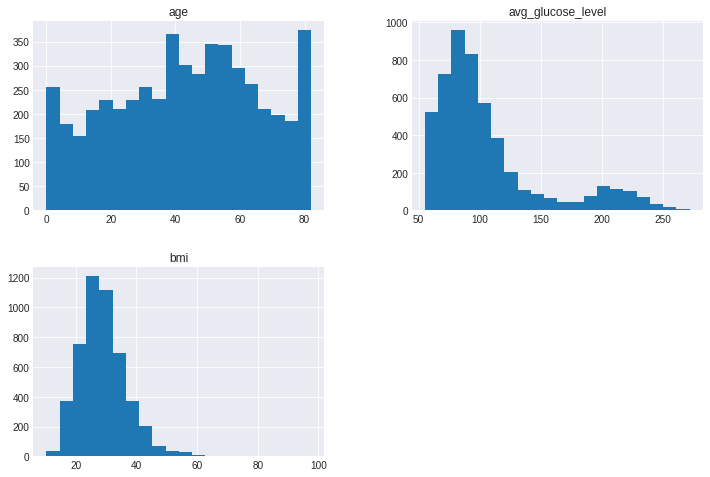

In [23]:
df[['age', 'avg_glucose_level', 'bmi']].hist(bins=20, figsize=(12,8))
plt.show()

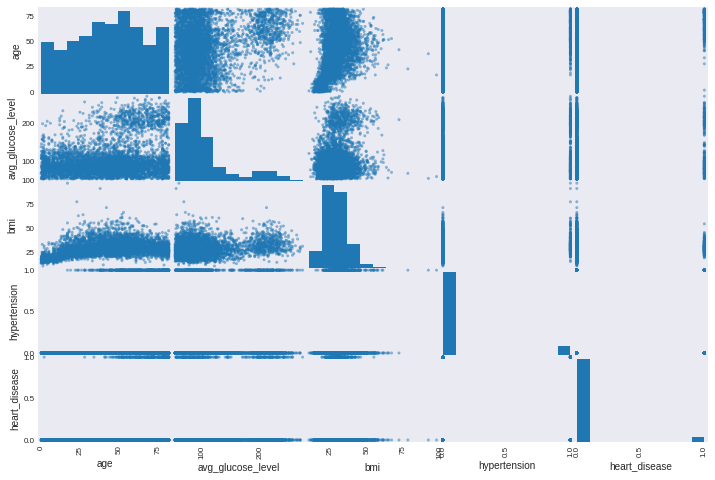

In [24]:
pd.plotting.scatter_matrix(df[['age', 'avg_glucose_level', 'bmi', 'hypertension', 'heart_disease']], figsize=(12,8))
plt.show()

In [25]:
print(df['hypertension'].unique())
print(df['heart_disease'].unique())
print(df['ever_married'].unique())
print(df['work_type'].unique())
print(df['Residence_type'].unique())
print(df['smoking_status'].unique())

[0 1]
[1 0]
['Yes' 'No']
['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
['Urban' 'Rural']
['formerly smoked' 'never smoked' 'smokes' 'Unknown']


In [26]:
X_train_classifiers = X_train[['hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'smoking_status']]

for col in X_train_classifiers.columns:
    print(f"Value counts for {col}")
    counts = df[col].value_counts()
    percentages = df[col].value_counts(normalize=True) * 100  # convert to percentage

    # combining counts and percentages in one DataFrame
    combined = pd.DataFrame({'Counts': counts, 'Percentage': percentages})
    print(combined)
    print()

Value counts for hypertension
   Counts  Percentage
0    4612   90.254403
1     498    9.745597

Value counts for heart_disease
   Counts  Percentage
0    4834   94.598826
1     276    5.401174

Value counts for ever_married
     Counts  Percentage
Yes    3353   65.616438
No     1757   34.383562

Value counts for work_type
               Counts  Percentage
Private          2925   57.240705
Self-employed     819   16.027397
children          687   13.444227
Govt_job          657   12.857143
Never_worked       22    0.430528

Value counts for Residence_type
       Counts  Percentage
Urban    2596   50.802348
Rural    2514   49.197652

Value counts for smoking_status
                 Counts  Percentage
never smoked       1892   37.025440
Unknown            1544   30.215264
formerly smoked     885   17.318982
smokes              789   15.440313



Summary from splitting the data:

- Stratifying the data on the target variable has created a training set which represents the original set successfully
- The distributions of Age, Average Glucose Level, and BMI all represent the original set which is important as we will transform and scale the data.
- The scatter matrix shows that the relationships and their strength have been maintained
- There are nulls in BMI which will need to be handled correctly
- As far as we can see all values are present for the categorical data:
    - ['Yes' 'No']
    - ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
    - ['Urban' 'Rural']
    - ['formerly smoked' 'never smoked' 'smokes' 'Unknown']


## Data Preprocessing

- Handle missing values
- Feature engineering
- Data scaling
- Encoding categorical variables

### Missing Values

BMI has some missing values that need to be dealt with. To do this, an assessment of the data is needed. Considerations are the following:
- what proportion of the overall data do the missing values account for
- it is expected that our model will receive missing values in production, the model should be able to deal with this and still make a prediction

In [27]:
# count the missing values in bmi
na_count = X_train['bmi'].isna().sum()

# percentage of missing values
total_values = X_train.shape[0]
na_percentage = (na_count/total_values) * 100

print(f"Missing values in bmi: {na_count}")
print(f"Percentage of missing values: {na_percentage:.2f}%")

Missing values in bmi: 170
Percentage of missing values: 4.16%


The total percentage is < 5% and generally, with a missing value percentage under 5% it is acceptable to drop the missing values, however, the model should handle them in production and the values can be imputed.

Considerations:
- bmi has no strong or medium relationship to other values in the dataset directly
- it may be that other factors in lifestyle which are not available to the dataset contribute more heavily to the data
- bmi does not follow a normal distribution, as tests proved earlier in the data exploration
- non-normal data would not work effectively with mean, as mean is sensitive to outliers it would introduce bias
- median may still be an option give the distribution of the data, the central value would hold no bias and could work.
- mode is not efffective for continuous data.
- a KNN model could be an improvement if median does not work effectively, this will be tested

Next step: build a median imputer for the bmi feature

In [28]:
median_imputer = SimpleImputer(strategy='median')

# select the data we want to work with
bmi_values = X_train[['bmi']]

X_train['imputed_bmi'] = median_imputer.fit_transform(bmi_values)

In [29]:
X_train['imputed_bmi'].isna().sum()

0

In [30]:
# display rows where 'bmi' is NaN, along with corresponding 'imputed_bmi' values
X_train[X_train['bmi'].isna()][['bmi', 'imputed_bmi']].head()

,bmi,imputed_bmi
2828,NaN,28.0
1866,NaN,28.0
3681,NaN,28.0
84,NaN,28.0
479,NaN,28.0


In [31]:
X_train.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'imputed_bmi'],
      dtype='object')

# Establishing a Baseline

The data has no missing values and it is ready for a baseline model to be established. The baseline model chosen is a Random Forest Classifier, for the following reasons:

- The data does not require any standardisation/normalisation
- Only the encoding of categorical variables would be required
- a simple pipeline can be made to satisfy the requirements and improvements can be measure against this baseline

## Steps:

- split the data with a stratified target variable
- make a pipeline that holds the impute and encoding transformations
- train and fit the model
- assess the model performance

In [32]:
# split the data using the exact same split we assessed before - hence the random seed being set
baseline_X_train, baseline_X_test, baseline_y_train, baseline_y_test = train_test_split(X, y, test_size= 0.2, random_state=42, stratify=y)

# create bmi pipeline
baseline_bmi_pipeline = make_pipeline(SimpleImputer(strategy='median')
                                     )


# one hot encode categorical data
baseline_categorical_transformer = make_pipeline(OneHotEncoder()
                                                )

# baseline preprocessing pipeline
baseline_preprocess_pipeline = ColumnTransformer(
    transformers = [
    ('bmi_pipeline', baseline_bmi_pipeline, ['bmi']),
    ('one_hot_encoder', baseline_categorical_transformer, ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'])
    ],
    remainder='passthrough'
)

# test the preprocessing
preprocess_result = baseline_preprocess_pipeline.fit_transform(baseline_X_train)

In [33]:
def get_feature_names(column_transformer, input_features):
    """Get feature names from all transformers."""
    output_features = []

    for name, pipe, features in column_transformer.transformers_:
        if name == 'remainder':
            # Getting the corresponding column names
            corresponding_columns = [input_features[label] for label in features]
            output_features.extend(corresponding_columns)
        else:
            for i in pipe:
                if hasattr(i, 'categories_'):
                    categories = i.categories_
                    for j in range(len(features)):
                        output_features.extend([f'{features[j]}_{category}' for category in categories[j]])
                else:
                    output_features.extend(features)

    return output_features

# Assuming 'preprocessor' is your ColumnTransformer
feature_names = get_feature_names(baseline_preprocess_pipeline, baseline_X_train.columns)
print(feature_names)

['bmi', 'gender_Female', 'gender_Male', 'gender_Other', 'ever_married_No', 'ever_married_Yes', 'work_type_Govt_job', 'work_type_Never_worked', 'work_type_Private', 'work_type_Self-employed', 'work_type_children', 'Residence_type_Rural', 'Residence_type_Urban', 'smoking_status_Unknown', 'smoking_status_formerly smoked', 'smoking_status_never smoked', 'smoking_status_smokes', 'age', 'hypertension', 'heart_disease', 'avg_glucose_level']


In [34]:
preprocess_result.shape

len(feature_names) # result shows that the names and shape of the results match

21

In [35]:
# Initiate an instance of the RandomForestClassifier with some starting default values - 100 trees, and a max depth for the trees set to 11 for the number of original features
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=11, random_state=42)

baseline_full_pipeline = Pipeline(steps=[
                                    ('preprocessor', baseline_preprocess_pipeline),
                                    ('classifier', rf_classifier)
                                ])

In [36]:
baseline_full_pipeline.fit(baseline_X_train, baseline_y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('bmi_pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['bmi']),
                                                 ('one_hot_encoder',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder())]),
                                                  ['gender', 'ever_married',
                                                   'work_type',
                                                   'Residence_type',
                                                   'smoking_status'])])),
                ('classifier',
                 RandomForestClassifie

In [37]:
from sklearn.metrics import accuracy_score, classification_report

# make predictions
predictions = baseline_full_pipeline.predict(baseline_X_test)

# evaluate the predictions
accuracy = accuracy_score(baseline_y_test, predictions)
print(f"Model Accuracy: {accuracy}")
print(classification_report(y_test, predictions))

Model Accuracy: 0.9500978473581213
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.33      0.02      0.04        50

    accuracy                           0.95      1022
   macro avg       0.64      0.51      0.51      1022
weighted avg       0.92      0.95      0.93      1022



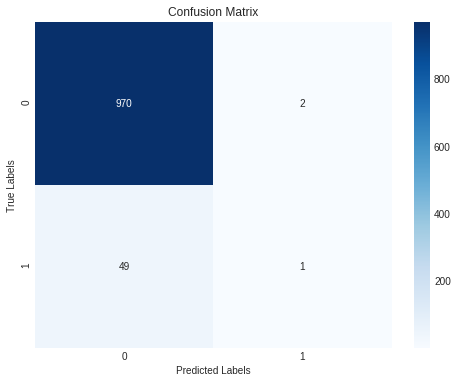

In [38]:
conf_matrix = confusion_matrix(baseline_y_test, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [39]:
conf_matrix

array([[970,   2],
       [ 49,   1]])

### Interpreting the Results

#### Accuracy (95.01%)
The model makes accurate predictions 95.01% of the time. This looks like it is good but in the context of a binary classifier the results must be considered alongside the data, and each class of event must be considered individually.

#### Class 0 (No Stroke)
- Precision (95%): 95% of events predicted as class 0 are actually class 0
- Recall (100%): The model identified 100% of actual events of class 0
- F1-Score (97%): For class 0 the F1-score indicates a good balance between precision and recall

#### Class 1 (Stroke)
- Precision (33%): The model is not able to predict class 1 events with a high degree of accuracy. The result indicates that 67% of the events predicted as class 1 events are false positives
- Recall (2%): Of the total possible predicted class 1 events, the model only predicted 2% of them accurately. The result tells us that 98% of the possible correct predictions are false negatives. This is not good for something as important as a stroke prediction, the model coul make a false positives and be accepted, but false negatives would be unacceptable
- F1-Score (4%): For class 1 the F1-Score indicates the poor performance of precision and recall

#### Confusion Matrix
The confusion matrix [970, 2], [49, 1] can be interpreted as follows:

- True Negative (TN = 970): The model correctly predicted the negative class (class 0) 970 times.
- False Positive (FP = 2): The model incorrectly predicted the positive class (class 1) 2 times when it was actually class 0.
- False Negative (FN = 49): The model incorrectly predicted the negative class 49 times when it was actually class 1.
- True Positive (TP = 1): The model correctly predicted the positive class only once.


#### Interpretation and Considerations
- Imbalanced Dataset: The high accuracy may be misleading due to class imbalance (972 instances of class 0 vs 50 of class 1). The model is very good at predicting the majority class (0) but performs poorly on the minority class (1).
- Class 1 Performance: The low recall and F1-score for class 1 suggest the model struggles to correctly identify positive cases. This is a common issue in imbalanced datasets.
- Model Bias: The model is biased towards predicting the majority class. Even though the overall accuracy is high, it is not performing well in terms of identifying the more critical minority class.
- Improvements: 
    - Resampling techniques are needed to better handle the class imbalance.
    - Hyperparameters and weighting of target importance can be tuned in the model.
    - Other models can be tested

### Resampling

Without making any major adjustments to the baseline pipelines, it is important to test the effect of resampling the data before making any model adjustments. The data work should happen before model tuning as it is a universal improvement regardless of the model being used.

Considerations:
- the dataset is note large, therefore, maintaining information and data is critical
- the ratio of positive to negative cases is relatively severe, and the true number of positive cases is not large enough to train the model effectively

Decision:
Due to the considerations above, the decision is to oversample the minority class. Initially, the smote method will be used in order to resample the data. Smote synthetically creates new samples of the minority class using a k-nearest neighbours technique. https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

### Steps:
- split the data
- preprocess the data to numeric information
- resample the data
- fit the model and predict

In [40]:
# Declare the feature and target datasets
X = df.drop(['id', 'stroke'], axis=1)
y = df['stroke']

# split the data using the exact same split we assessed before - hence the random seed being set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42, stratify=y)

# create bmi pipeline
bmi_pipeline = make_pipeline(SimpleImputer(strategy='median')
                                     )

# one hot encode categorical data
categorical_transformer = make_pipeline(OneHotEncoder()
                                                )

# preprocessing pipeline
preprocess_pipeline = ColumnTransformer(
    transformers = [
    ('bmi_pipeline', baseline_bmi_pipeline, ['bmi']),
    ('one_hot_encoder', baseline_categorical_transformer, ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'])
    ],
    remainder='passthrough'
)

# preprocess the data

preprocessed_X_train = preprocess_pipeline.fit_transform(X_train)

# instantiate smote
smote = SMOTE(random_state=42)

# Resample only the training data
X_resampled, y_resampled = smote.fit_resample(preprocessed_X_train, y_train)



In [41]:
class_distribution_before = y_train.value_counts()
print("Class distribution before resampling:\n", class_distribution_before)

class_distribution_after = y_resampled.value_counts()
print("Class distribution after resampling:\n", class_distribution_after)

Class distribution before resampling:
 0    3889
1     199
Name: stroke, dtype: int64
Class distribution after resampling:
 1    3889
0    3889
Name: stroke, dtype: int64


After resampling there is an even number of class events between 0 and 1. 

Having tested the resampling, create the pipeline, redefine the input data then run the model and reassess the results.

In [42]:
# Declare the feature and target datasets
X = df.drop(['id', 'stroke'], axis=1)
y = df['stroke']

# split the data using the exact same split we assessed before - hence the random seed being set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42, stratify=y)

# create bmi pipeline
bmi_pipeline = make_pipeline(SimpleImputer(strategy='median')
                                     )

# one hot encode categorical data
categorical_transformer = make_pipeline(OneHotEncoder()
                                                )

# preprocessing pipeline
preprocess_pipeline = ColumnTransformer(
    transformers = [
    ('bmi_pipeline', baseline_bmi_pipeline, ['bmi']),
    ('one_hot_encoder', baseline_categorical_transformer, ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'])
    ],
    remainder='passthrough'
)


# instantiate smote
smote = SMOTE(random_state=42)

# Re-Initiate an instance of the RandomForestClassifier with the same starting default values - 100 trees, and a max depth for the trees set to 11 for the number of original features
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=11, random_state=42)

resampled_pipeline = ImbPipeline(steps=[
                                    ('preprocessor', preprocess_pipeline),
                                    ('smote', smote),
                                    ('classifier', rf_classifier)
                                ]
                                )

In [43]:
# train the model
resampled_pipeline.fit(X_train, y_train)

predictions = resampled_pipeline.predict(X_test)


Model Accuracy: 0.9500978473581213
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.43      0.06      0.11        50

    accuracy                           0.95      1022
   macro avg       0.69      0.53      0.54      1022
weighted avg       0.93      0.95      0.93      1022






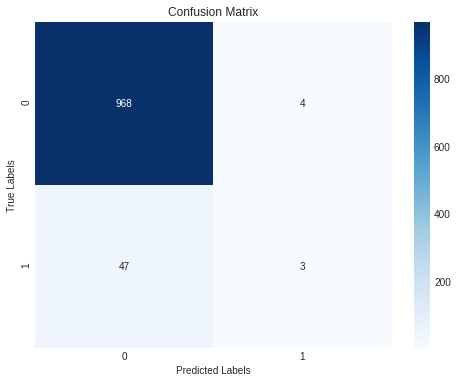

In [44]:
# evaluate the predictions
accuracy = accuracy_score(baseline_y_test, predictions)
print(f"Model Accuracy: {accuracy}")
print(classification_report(y_test, predictions))
print("\n\n")

conf_matrix = confusion_matrix(y_test, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### Interpreting the Results

#### Accuracy (95.01%)
The model makes accurate predictions 95.01% of the time. This looks like it is good but in the context of a binary classifier the results must be considered alongside the data, and each class of event must be considered individually.

#### Class 0 (No Stroke) - no real change
- Precision (95%): 95% of events predicted as class 0 are actually class 0
- Recall (100%): The model identified 100% of actual events of class 0
- F1-Score (97%): For class 0 the F1-score indicates a good balance between precision and recall

#### Class 1 (Stroke) - slight change
- Precision (43%): The model is not able to predict class 1 events with a high degree of accuracy. The result indicates that 57% of the events predicted as class 1 events are false positives
- Recall (6%): Of the total possible predicted class 1 events, the model only predicted 2% of them accurately. The result tells us that 98% of the possible correct predictions are false negatives. This is not good for something as important as a stroke prediction, the model coul make a false positives and be accepted, but false negatives would be unacceptable
- F1-Score (11%): For class 1 the F1-Score indicates the poor performance of precision and recall

#### Confusion Matrix
The confusion matrix [968, 4], [47, 3] can be interpreted as follows:

- True Negative (TN = 968): The model correctly predicted the negative class (class 0) 968 times.
- False Positive (FP = 4): The model incorrectly predicted the positive class (class 1) 4 times when it was actually class 0.
- False Negative (FN = 47): The model incorrectly predicted the negative class 47 times when it was actually class 1.
- True Positive (TP = 3): The model correctly predicted the positive class only 3 times.


#### Interpretation and Considerations
- Imbalanced Dataset: We addressed the class imblance in training, however this resulted in no significant change to results
- Class 1 Performance: The low recall and F1-score for class 1 suggest the model struggles to correctly identify positive cases. This is a common issue in imbalanced datasets.
- Model Bias: The model is biased towards predicting the majority class. Even though the overall accuracy is high, it is not performing well in terms of identifying the more critical minority class.
- Improvements: 
    - Resampling techniques: Refine knn value in smote
    - Hyperparameters and weighting of target importance can be tuned in the model.
    - Other models can be tested
    - Feature Engineering

### Refined knn in SMOTE and Weighting of classes

In the randomforest the weights can be adjust for the classes. The weighting to be applied are: class 0 : 1, class 1: 10.

The knn value in smote can be adjusted for smaller or larger datasets. The default is 5, and with the size of the data set being small, this value can be revised to 3.

Below, is a revised pipeline taking into account the weighting and the sampling strategy.

In [45]:
# Declare the feature and target datasets
X = df.drop(['id', 'stroke'], axis=1)
y = df['stroke']

# split the data using the exact same split we assessed before - hence the random seed being set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42, stratify=y)

# create bmi pipeline
bmi_pipeline = make_pipeline(SimpleImputer(strategy='median')
                                     )

# one hot encode categorical data
categorical_transformer = make_pipeline(OneHotEncoder()
                                                )

# preprocessing pipeline
preprocess_pipeline = ColumnTransformer(
    transformers = [
    ('bmi_pipeline', baseline_bmi_pipeline, ['bmi']),
    ('one_hot_encoder', categorical_transformer, ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'])
    ],
    remainder='passthrough'
)


# instantiate smote
smote = SMOTE(k_neighbors=3, random_state=42)

# Re-Initiate an instance of the RandomForestClassifier with the same starting default values - 100 trees, and a max depth for the trees set to 11 for the number of original features
# introduce a class_weight parameter into the random forest
weights = {0:1, 1:10}
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=11, random_state=42, class_weight=weights)

resampled_pipeline = ImbPipeline(steps=[
                                    ('preprocessor', preprocess_pipeline),
                                    ('smote', smote),
                                    ('classifier', rf_classifier)
                                ]
                                )

Model Accuracy: 0.8483365949119374
              precision    recall  f1-score   support

           0       0.96      0.88      0.92       972
           1       0.12      0.32      0.17        50

    accuracy                           0.85      1022
   macro avg       0.54      0.60      0.54      1022
weighted avg       0.92      0.85      0.88      1022






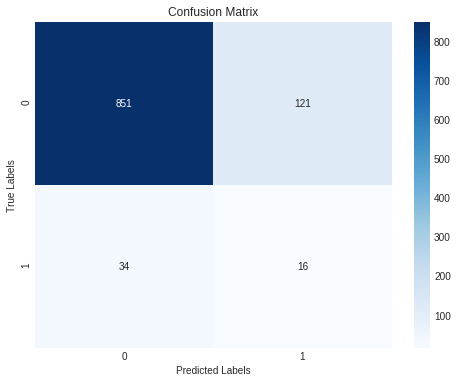

In [46]:
# train and predict the model
resampled_pipeline.fit(X_train, y_train)

predictions = resampled_pipeline.predict(X_test)

# evaluate the predictions
accuracy = accuracy_score(y_test, predictions)
print(f"Model Accuracy: {accuracy}")
print(classification_report(y_test, predictions))
print("\n\n")

conf_matrix = confusion_matrix(y_test, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### Interpreting the Results

#### Accuracy (84.83%)
The model makes accurate predictions 84.83% of the time. The dramatic decrease in accuracy, surprisingly results in a slightly better model as will be explained below.

#### Class 0 (No Stroke) - no real change
- Precision (96%): 96% of events predicted as class 0 are actually class 0
- Recall (88%): The model identified 88% of actual events of class 0
- F1-Score (92%): For class 0 the F1-score indicates a good balance between precision and recall

#### Class 1 (Stroke) - slight change
- Precision (12%): The model is not able to predict class 1 events with a high degree of accuracy. The result indicates that 88% of the events predicted as class 1 events are false positives
- Recall (32%): Of the total possible predicted class 1 events, the model only predicted 32% of them accurately (this is a large increase on the previous results). The result tells us that 68% of the possible correct predictions are false negatives. This is not good for something as important as a stroke prediction, the model could make a false positives and be accepted, but false negatives would be unacceptable
- F1-Score (17%): For class 1 the F1-Score indicates the poor performance of precision and recall, though better than previously performed.

#### Confusion Matrix
The confusion matrix [968, 4], [47, 3] can be interpreted as follows:

- True Negative (TN = 861): The model correctly predicted the negative class (class 0) 861 times.
- False Positive (FP = 121): The model incorrectly predicted the positive class (class 1) 121 times when it was actually class 0.
- False Negative (FN = 34): The model incorrectly predicted the negative class 34 times when it was actually class 1.
- True Positive (TP = 16): The model correctly predicted the positive class only 16 times.


#### Interpretation and Considerations
- Imbalanced Dataset: We further tuned the class imbalance for the smaller dataset and this allowed the training of the model to perform better, along with the class weighting in the model.
- Class 1 Performance: The low recall and F1-score for class 1 suggest the model still struggles to correctly identify positive cases.
- Model Bias: The model has lost some of the bias towards predicting the majority class. Even though the overall accuracy is high, it is not performing well in terms of identifying the more critical minority class, and it is still producing an unacceptable level of false negatives
- Improvements Next Steps: 
    - Feature engineering may assist the model in enhancing it's ability to train and model effectively. This will be the next step to be looked at.
    - Other models can be tested

### Feature Engineering

- Categorical grouping of age, bmi, and average glucose level may allow for a more accurate model by grouping together the data and making certain classes stand out in the model
    - Age can be categorised into youth < 20, young adult 20 =< 40, mature adult =< 60, senior adult > 60
    - BMI can be grouped into underweight < 18.5, normal weight 18.5 <= 24.9, overweight 24.9 <= 29.9, and obese 30.0 =< according to the centre for disease control: https://www.cdc.gov/healthyweight/assessing/bmi/adult_bmi/index.html
    - Average Glucose Levels can be categorised as normal <= 99, pre-diabetic 99 <= 125, and diabetic 126 < levels of blood sugar according to the centre for disease control https://www.cdc.gov/diabetes/basics/getting-tested.html
    
    
- Health Risk Score can be created from indicators such as hypertension, heart disease, bmi, and smoking status.
- Similarly a lifestyle score can be created using work type and residence type

In [47]:
# Prepare data for feature engineering

# Declare the feature and target datasets
X = df.drop(['id', 'stroke'], axis=1)
y = df['stroke']

# split the data using the exact same split we assessed before - hence the random seed being set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42, stratify=y)

To make the classifications for age, bmi, and average glucose level, the conditions and the choices they fall under are declared, then using np.select they are matched across the dataframe for the relevant data, and the default is set to 'Not Specified'.

In [48]:
def categorise_age(df):

    # conditions and choices for age category
    conditions_age = [
        df['age'] < 20,
        (df['age'] >= 20) & (df['age'] <= 40),
        (df['age'] > 40) & (df['age'] <= 60),
        df['age'] > 60
    ]
    choices_age = ['youth', 'young adult', 'mature adult', 'senior adult']
    df['age_category'] = np.select(conditions_age, choices_age, default='Not Specified')
    
    return df

def categorise_bmi(df):

    # conditions and choices for BMI category
    conditions_bmi = [
        df['imputed_bmi'] < 18.5,
        (df['imputed_bmi'] >= 18.5) & (df['imputed_bmi'] <= 24.9),
        (df['imputed_bmi'] > 24.9) & (df['imputed_bmi'] <= 29.9),
        df['imputed_bmi'] > 29.9
    ]
    choices_bmi = ['underweight', 'normal weight', 'overweight', 'obese']
    df['bmi_category'] = np.select(conditions_bmi, choices_bmi, default='Not Specified')
    
    return df

def categorise_glucose(df):

    # conditions and choices for average glucose level category
    conditions_glucose = [
        df['avg_glucose_level'] <= 99,
        (df['avg_glucose_level'] > 99) & (df['avg_glucose_level'] <= 125),
        df['avg_glucose_level'] > 125
    ]
    choices_glucose = ['normal', 'pre-diabetic', 'diabetic']
    df['glucose_category'] = np.select(conditions_glucose, choices_glucose, default='Not Specified')
    
    return df


In [49]:
median_imputer = SimpleImputer(strategy='median')

# select the data we want to work with
bmi_values = X_train[['bmi']]

X_train['imputed_bmi'] = median_imputer.fit_transform(bmi_values)

X_train = categorise_age(X_train)
X_train = categorise_bmi(X_train)
X_train = categorise_glucose(X_train)

### Health Risk Score

Health risk score is a composite score that combines multiple health indicators by assigning points based on various risk factors. To produce this score, we can use the categories just created along with other metrics. The breakdown of the score is as follows:

Health risk increases as Age increases

Where Age Category = mature adult, score + 1
Where Age Category = senior adult, score + 2
Otherwise no addition to score

Underweight, and overweight/obese people are a higher health risk

Where BMI Category = underweight, score + 1
Where BMI Category = overweight, score + 1
Where BMI Category = obese, score + 2
Otherwise no addition to score

Diabetics and pre-diabetics carry more risks associated with the disease

Where Glucose Category = pre-diabetic, score + 1
Where Glucose Category = diabetic, score + 2
Otherwise no addition to score

Smokers, and past smokers are a higher health risk compared to non-smokers

Where Smoking Status = smokes, score + 2
Where Smoking Status = formerly smoked, score + 1
Otherwise no addition to score

Hypertension/high blood pressure has a negative impact on a person's health and especially their heart

Where Hypertension = 1, score + 1
Otherwise no addition to score

The presence of a heart disease raises the risk of a person suffering a stroke

Where Heart Disease = 1, score + 1
Otherwise no addition to score



In [50]:
def calculate_health_risk_score(row):
    score = 0
    # Age score
    score += 1 if row['age_category'] == 'mature adult' else 0
    score += 2 if row['age_category'] == 'senior adult' else 0

    # BMI score
    if row['bmi_category'] == 'underweight': score += 1
    elif row['bmi_category'] == 'overweight': score += 1
    elif row['bmi_category'] == 'obese': score += 2

    # Glucose score
    score += 1 if row['glucose_category'] == 'pre-diabetic' else 0
    score += 2 if row['glucose_category'] == 'diabetic' else 0

    # Smoking score
    score += 2 if row['smoking_status'] == 'smokes' else 0
    score += 1 if row['smoking_status'] == 'formerly smoked' else 0

    # Hypertension and heart disease score
    score += row['hypertension'] + row['heart_disease']

    return score


X_train['health_risk_score'] = X_train.apply(calculate_health_risk_score, axis=1)


In [51]:
X_train.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,imputed_bmi,age_category,bmi_category,glucose_category,health_risk_score
845,Female,48.0,0,0,Yes,Private,Urban,69.21,33.1,never smoked,33.1,mature adult,obese,normal,3
3744,Male,15.0,0,0,No,Private,Rural,122.25,21.0,never smoked,21.0,youth,normal weight,pre-diabetic,1
4183,Female,67.0,0,0,Yes,Self-employed,Rural,110.42,24.9,never smoked,24.9,senior adult,normal weight,pre-diabetic,3
3409,Male,44.0,0,0,Yes,Private,Urban,65.41,24.8,smokes,24.8,mature adult,normal weight,normal,3
284,Male,14.0,0,0,No,Govt_job,Urban,82.34,31.6,Unknown,31.6,youth,obese,normal,2


### Lifestyle Score

Lifestyle score is a composite score that combines multiple lifestyle indicators by assigning points based on various attributes factors. To produce this score, we can use the categories present in the data. The breakdown of the score is as follows:

Marriage, or sharing a life with someone is assumed to be a positive impact on your lifestyle

Where ever married = Yes, score + 1

Otherwise no addition to score

The work type will be scored according to sedentary and non-sedentary work, where 'Private', 'Self-employed', and 'Govt_job' are considered sedentary, though self employed people are going to be assumed to be successful and happy in their profession choice, while 'children' and 'Never_worked' are considered non-sedentary

Where Work Type = 'Private', or 'Govt_job', score + 0

Where Work Type = 'Self-employed', score + 1

Where Work Type = 'children' and 'Never_worked', score + 2

Otherwise no addition to score

A rural residence is assumed to be more active and healthy compared to an urban residence.

Where Residence Type = Urban, score + 0

Where Residence Type = Rural, score + 1

It is assumed that people who have never smoked make better lifestyle choices

Where Smoking Status = never smoked, score + 2

Where Smoking Status = formerly smoked, score + 1

Otherwise no addition to score


In [52]:
def calculate_lifestyle_score(row):
    score = 0
    
    # Scoring for marital status
    score += 1 if row['ever_married'] == 'Yes' else 0

    # Scoring for work type
    # No points for 'Private', 'Self-employed', or 'Govt_job'
    # 1 point for 'children' and 'Never_worked'
    if row['work_type'] in ['children', 'Never_worked']:
        score += 2
    elif row['work_type'] == 'Self-employed':
        score += 1

    # Scoring for residence type
    # 1 point for 'Rural', no points for 'Urban'
    score += 1 if row['Residence_type'] == 'Rural' else 0

    # Scoring for smoking status
    score += 2 if row['smoking_status'] == 'never smoked' else 0
    score += 1 if row['smoking_status'] == 'formerly smoked' else 0

    return score

# Applying the scoring function to each row
X_train['lifestyle_score'] = X_train.apply(calculate_lifestyle_score, axis=1)

In [53]:
X_train.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,imputed_bmi,age_category,bmi_category,glucose_category,health_risk_score,lifestyle_score
845,Female,48.0,0,0,Yes,Private,Urban,69.21,33.1,never smoked,33.1,mature adult,obese,normal,3,3
3744,Male,15.0,0,0,No,Private,Rural,122.25,21.0,never smoked,21.0,youth,normal weight,pre-diabetic,1,3
4183,Female,67.0,0,0,Yes,Self-employed,Rural,110.42,24.9,never smoked,24.9,senior adult,normal weight,pre-diabetic,3,5
3409,Male,44.0,0,0,Yes,Private,Urban,65.41,24.8,smokes,24.8,mature adult,normal weight,normal,3,1
284,Male,14.0,0,0,No,Govt_job,Urban,82.34,31.6,Unknown,31.6,youth,obese,normal,2,0


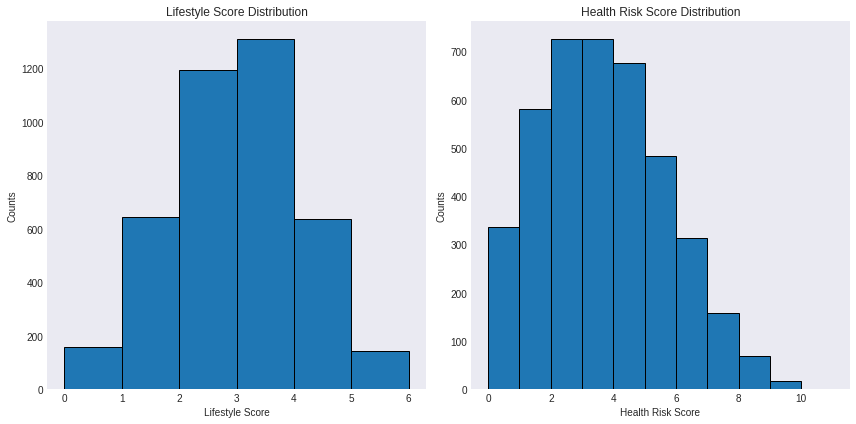

In [54]:
plt.figure(figsize=(12, 6))

# Histogram for lifestyle score
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.hist(X_train['lifestyle_score'], bins=range(int(X_train['lifestyle_score'].min()), int(X_train['lifestyle_score'].max()) + 2), edgecolor='black')
plt.title('Lifestyle Score Distribution')
plt.xlabel('Lifestyle Score')
plt.ylabel('Counts')

# Histogram for health risk score
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.hist(X_train['health_risk_score'], bins=range(int(X_train['health_risk_score'].min()), int(X_train['health_risk_score'].max()) + 2), edgecolor='black')
plt.title('Health Risk Score Distribution')
plt.xlabel('Health Risk Score')
plt.ylabel('Counts')

plt.tight_layout()
plt.show()

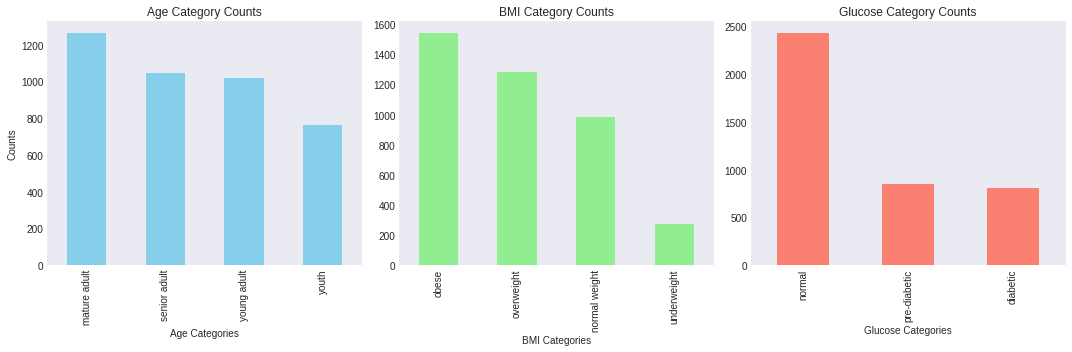

In [55]:
# Plotting the bar charts
plt.figure(figsize=(15, 5))

# Bar chart for age_category counts
plt.subplot(1, 3, 1)
X_train['age_category'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Age Category Counts')
plt.xlabel('Age Categories')
plt.ylabel('Counts')

# Bar chart for bmi_category counts
plt.subplot(1, 3, 2)
X_train['bmi_category'].value_counts().plot(kind='bar', color='lightgreen')
plt.title('BMI Category Counts')
plt.xlabel('BMI Categories')

# Bar chart for glucose_category counts
plt.subplot(1, 3, 3)
X_train['glucose_category'].value_counts().plot(kind='bar', color='salmon')
plt.title('Glucose Category Counts')
plt.xlabel('Glucose Categories')

plt.tight_layout()
plt.show()

Feature engineering is now completed and checked with some visualisations. Note that the class imbalance has not been dealt with. It is good to get a baseline score on the models without addressing the class imbalance.

The next step is to prepare the pipelines to include the features which are being engineered.

In [56]:
# Prepare data for modelling with the new features

# Declare the feature and target datasets
X = df.drop(['id', 'stroke'], axis=1)
y = df['stroke']

# split the data using the exact same split we assessed before - hence the random seed being set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42, stratify=y)

In [56]:
# imputer function
def impute_bmi(df):
    
    median_imputer = SimpleImputer(strategy='median')

    # select the data we want to work with
    bmi_values = df[['bmi']]

    df['bmi'] = median_imputer.fit_transform(df[['bmi']])
    
    return df

In [57]:
# Create the categorical tranformers to incorporate into the pipeline

def categorise_age(df):

    # conditions and choices for age category
    conditions_age = [
        df['age'] < 20,
        (df['age'] >= 20) & (df['age'] <= 40),
        (df['age'] > 40) & (df['age'] <= 60),
        df['age'] > 60
    ]
    choices_age = ['youth', 'young adult', 'mature adult', 'senior adult']
    df['age_category'] = np.select(conditions_age, choices_age, default='Not Specified')
    
    return df

def categorise_bmi(df):

    # conditions and choices for BMI category
    conditions_bmi = [
        df['bmi'] < 18.5,
        (df['bmi'] >= 18.5) & (df['bmi'] <= 24.9),
        (df['bmi'] > 24.9) & (df['bmi'] <= 29.9),
        df['bmi'] > 29.9
    ]
    choices_bmi = ['underweight', 'normal weight', 'overweight', 'obese']
    df['bmi_category'] = np.select(conditions_bmi, choices_bmi, default='Not Specified')
    
    return df

def categorise_glucose(df):

    # conditions and choices for average glucose level category
    conditions_glucose = [
        df['avg_glucose_level'] <= 99,
        (df['avg_glucose_level'] > 99) & (df['avg_glucose_level'] <= 125),
        df['avg_glucose_level'] > 125
    ]
    choices_glucose = ['normal', 'pre-diabetic', 'diabetic']
    df['glucose_category'] = np.select(conditions_glucose, choices_glucose, default='Not Specified')
    
    return df

In [58]:
# Create the Health Risk Score transformer to incorporate into the pipeline

def calculate_health_risk_scores(df):
    # Initialize the score column
    df['health_risk_score'] = 0

    # Calculate scores based on conditions
    df['health_risk_score'] += df['age_category'].map({'mature adult': 1, 'senior adult': 2}).fillna(0)
    df['health_risk_score'] += df['bmi_category'].map({'underweight': 1, 'overweight': 1, 'obese': 2}).fillna(0)
    df['health_risk_score'] += df['glucose_category'].map({'pre-diabetic': 1, 'diabetic': 2}).fillna(0)
    df['health_risk_score'] += df['smoking_status'].map({'smokes': 2, 'formerly smoked': 1}).fillna(0)

    # Add points for hypertension and heart disease
    df['health_risk_score'] += df[['hypertension', 'heart_disease']].sum(axis=1)

    # Return only the health_risk_score column as output
    return df

In [59]:
# Create the Lifestyle Score transformer to incorporate into the pipeline

def calculate_lifestyle_scores(df):
    # Initialize the score column
    df['lifestyle_score'] = 0

    # Calculate scores based on conditions
    df['lifestyle_score'] += df['ever_married'].map({'Yes': 1}).fillna(0)

    # Scoring for work type
    work_type_scores = {'children': 2, 'Never_worked': 2, 'Self-employed': 1}
    df['lifestyle_score'] += df['work_type'].map(work_type_scores).fillna(0)

    # Scoring for residence type
    df['lifestyle_score'] += df['Residence_type'].map({'Rural': 1}).fillna(0)

    # Scoring for smoking status
    smoking_status_scores = {'never smoked': 2, 'formerly smoked': 1}
    df['lifestyle_score'] += df['smoking_status'].map(smoking_status_scores).fillna(0)

    # Return only the lifestyle_score column as output
    return df

In [60]:
class CustomPreprocessor(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.original_categorical_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
        self.encoder = OneHotEncoder(handle_unknown='ignore')
        # Combine original and new categorical columns
        self.all_categorical_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status', 'age_category', 'bmi_category', 'glucose_category']
        
        
    def fit(self, X, y=None):
        # Apply custom transformations to create new categorical columns
        X_temp = categorise_age(X.copy(deep=True))

        X_temp = categorise_bmi(X_temp)

        X_temp = categorise_glucose(X_temp)

        # Fit the encoder for all categorical columns
        if set(self.all_categorical_cols).issubset(X_temp.columns):
            self.encoder.fit(X_temp[self.all_categorical_cols])
        else:
            missing_cols = set(self.all_categorical_cols) - set(X_temp.columns)
            raise ValueError(f"Missing columns for encoding: {missing_cols}")

        # Fit the imputer for 'bmi'
        self.imputer = SimpleImputer(strategy='median')
        self.imputer.fit(X[['bmi']])
        
        return self


    def transform(self, X):
        # Apply impute_bmi
        X['bmi'] = self.imputer.transform(X[['bmi']])

        # Apply custom categorization functions
        X = categorise_age(X)
        X = categorise_bmi(X)
        X = categorise_glucose(X)
        X = calculate_health_risk_scores(X)
        X = calculate_lifestyle_scores(X)

        # Combine original and new categorical columns
        all_categorical_cols = self.original_categorical_cols + ['age_category', 'bmi_category', 'glucose_category']

        # One-hot encode all categorical columns
        encoded_cats = self.encoder.transform(X[all_categorical_cols]).toarray()
        encoded_cat_df = pd.DataFrame(encoded_cats, columns=self.encoder.get_feature_names(all_categorical_cols), index=X.index)

        # Drop the original and new categorical columns
        X.drop(columns=all_categorical_cols, inplace=True)

        # Concatenate the one-hot encoded columns with the rest of the DataFrame
        return pd.concat([X, encoded_cat_df], axis=1)

In [62]:
#data_check = CustomPreprocessor().fit_transform(X_train)

In [63]:
#data_check.head()

In [64]:
# instantiate smote
smote = SMOTE(k_neighbors=3, random_state=42)

# Re-Initiate an instance of the RandomForestClassifier with the same starting default values - 100 trees, and a max depth for the trees set to 11 for the number of original features
# maintain the class_weight parameter in the random forest
weights = {0:1, 1:10}
rf_model = RandomForestClassifier(n_estimators=100, max_depth=11, random_state=42, class_weight=weights)

rf_pipeline = ImbPipeline(steps=[
    ('preprocessor', CustomPreprocessor()),             # custom preprocessing and feature engineering
    ('smote', smote),                         # SMOTE for handling class imbalance
    ('classifier', rf_model)    # Random Forest classifier
])

Model Accuracy: 0.7818003913894325
              precision    recall  f1-score   support

           0       0.97      0.79      0.87       972
           1       0.12      0.54      0.19        50

    accuracy                           0.78      1022
   macro avg       0.55      0.67      0.53      1022
weighted avg       0.93      0.78      0.84      1022






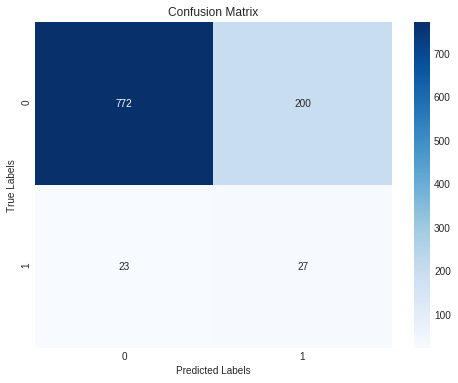

In [65]:
# train and predict the model
rf_pipeline.fit(X_train, y_train)

predictions = rf_pipeline.predict(X_test)

# evaluate the predictions
accuracy = accuracy_score(y_test, predictions)
print(f"Model Accuracy: {accuracy}")
print(classification_report(y_test, predictions))
print("\n\n")

conf_matrix = confusion_matrix(y_test, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [66]:
print(conf_matrix)

[[772 200]
 [ 23  27]]


### Interpreting the Results

#### Accuracy (78.18%)
The model makes accurate predictions 78.18% of the time. A further decrease in accuracy implies that the model is generalising results a bit more. To understand what this means for the goal of predicting a stroke, it requires us to look at the results for each class.

#### Class 0 (No Stroke) - no real change
- Precision (97%): 97% of events predicted as class 0 are actually class 0, this is a slight increase on previous results
- Recall (79%): The model identified 79% of actual events of class 0, a decrease on previous results which indicates and increase in false positives.
- F1-Score (92%): For class 0 the F1-score indicates a good balance between precision and recall

#### Class 1 (Stroke) - slight change
- Precision (12%): The model is not able to predict class 1 events with a high degree of accuracy. The result indicates that 88% of the events predicted as class 1 events are false positives
- Recall (54%%): Of the total possible predicted class 1 events, the model predicted 54% of them accurately (this is a further increase on the previous results). The result tells us that 46% of the possible correct predictions are false negatives. This is still not good for something as important as a stroke prediction, the model could make a false positives and be accepted, but false negatives would be unacceptable
- F1-Score (19%): For class 1 the F1-Score indicates the poor performance of precision and recall, though better than previously performed.

#### Confusion Matrix
The confusion matrix [772, 200], [23, 27] can be interpreted as follows:

- True Negative (TN = 772): The model correctly predicted the negative class (class 0) 772 times.
- False Positive (FP = 200): The model incorrectly predicted the positive class (class 1) 200 times when it was actually class 0.
- False Negative (FN = 23): The model incorrectly predicted the negative class 23 times when it was actually class 1.
- True Positive (TP = 27): The model correctly predicted the positive class only 24 times.


#### Interpretation and Considerations
- Imbalanced Dataset: We further tuned the class imbalance for the smaller dataset and this allowed the training of the model to perform better, along with the class weighting in the model.
- Class 1 Performance: The recall and F1-score for class 1 suggests the model is improving in its ability to correctly identify positive cases. The F1-score will remain low though as the number of false positives increased
- Model Bias: The model is maintaining a bias to the majority class, however the number of true positives is increasing, this is a positive move forward for the model.
- Improvements Next Steps: 
    - Feature engineering succeeded in providing better results for True positives. Further feature engineering could include normalisation of the data.
    - Other models can be tested

### Feature Engineering Cont...

- Transformations
    - bmi needs to undergo a transformation to normalise the skewness of the data (left skew). This change will deal with outliers in the data and provide better data for the models, often regarded as not necessary for tree models, it will be necessary for models further down the line.
    - bmi can benefit from a log transformation
    - average glucose level has already been categorised, which is the general method of dealing with bimodal data.
    
- Data Scaling
    - Data scaling can enhance a model's performance significantly as it ensures all data are within the same scale.
    - Scaling can only be done after the transformation and other feature engineering factors take place
    
The above steps can be applied by making some changes to the CustomPreprocessor declared above.

N.B. log1p is used in the log transformation in case values are 0.

In [67]:
# reproduce the split of data
# Prepare data for modelling with the new features

# Declare the feature and target datasets
X = df.drop(['id', 'stroke'], axis=1)
y = df['stroke']

# split the data using the exact same split we assessed before - hence the random seed being set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42, stratify=y)

In [68]:
def log_transform(x):
    return np.log1p(x)  # log1p is used for log(x + 1)

Testing the log transformation and scaling

In [69]:
X_train['log_bmi'] = X_train['bmi'].apply(log_transform)

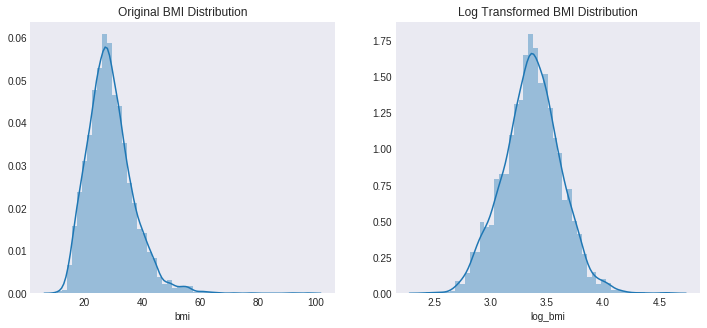

In [70]:
# Original bmi distribution vs Log transformed distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
sns.distplot(X_train['bmi'], kde=True, ax=ax1)
ax1.set_title('Original BMI Distribution')
sns.distplot(X_train['log_bmi'], kde=True, ax=ax2)
ax2.set_title('Log Transformed BMI Distribution')

plt.show()

From the plots it is clear to see that the transformations have worked and the distribution of bmi has been normalised. Adjust the CustomPreprocessor class to deal with these transformations.

In [77]:
class CustomPreprocessor(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.original_categorical_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
        self.encoder = OneHotEncoder(handle_unknown='ignore')
        # Combine original and new categorical columns
        self.all_categorical_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status', 'age_category', 'bmi_category', 'glucose_category']
        self.scaler = StandardScaler()
        
        
    def fit(self, X, y=None):
        # Apply custom transformations to create new categorical columns
        X_temp = categorise_age(X.copy(deep=True))

        X_temp = categorise_bmi(X_temp)

        X_temp = categorise_glucose(X_temp)

        # Fit the encoder for all categorical columns
        if set(self.all_categorical_cols).issubset(X_temp.columns):
            self.encoder.fit(X_temp[self.all_categorical_cols])
        else:
            missing_cols = set(self.all_categorical_cols) - set(X_temp.columns)
            raise ValueError(f"Missing columns for encoding: {missing_cols}")

        # Fit the imputer for 'bmi'
        self.imputer = SimpleImputer(strategy='median')
        self.imputer.fit(X[['bmi']])
        
        
        return self


    def transform(self, X):
        X = X.copy(deep=True)
        # Apply impute_bmi
        X['bmi'] = self.imputer.transform(X[['bmi']])

        # Apply custom categorization functions
        X = categorise_age(X)
        X = categorise_bmi(X)
        X = categorise_glucose(X)
        X = calculate_health_risk_scores(X)
        X = calculate_lifestyle_scores(X)

        # Combine original and new categorical columns
        all_categorical_cols = self.original_categorical_cols + ['age_category', 'bmi_category', 'glucose_category']
        
        # Apply transformations and scaling
        # Apply log transformation
        X[['bmi']] = np.log1p(X[['bmi']])
        # Standardize numerical columns
        self.scaler.fit(X[['age', 'avg_glucose_level', 'bmi', 'health_risk_score', 'lifestyle_score']])
        X[['age', 'avg_glucose_level', 'bmi', 'health_risk_score', 'lifestyle_score']] = self.scaler.transform(X[['age', 'avg_glucose_level', 'bmi', 'health_risk_score', 'lifestyle_score']])

        # One-hot encode all categorical columns
        encoded_cats = self.encoder.transform(X[all_categorical_cols]).toarray()
        encoded_cat_df = pd.DataFrame(encoded_cats, columns=self.encoder.get_feature_names(all_categorical_cols), index=X.index)

        # Drop the original and new categorical columns
        X.drop(columns=all_categorical_cols, inplace=True)

        # Concatenate the one-hot encoded columns with the rest of the DataFrame
        return pd.concat([X, encoded_cat_df], axis=1)

In [78]:
# reproduce the split of data
# Prepare data for modelling with the new features

# Declare the feature and target datasets
X = df.drop(['id', 'stroke'], axis=1)
y = df['stroke']

# split the data using the exact same split we assessed before - hence the random seed being set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42, stratify=y)

In [73]:
# instantiate smote
smote = SMOTE(k_neighbors=3, random_state=42)

# Re-Initiate an instance of the RandomForestClassifier with the same starting default values - 100 trees, and a max depth for the trees set to 11 for the number of original features
# maintain the class_weight parameter in the random forest
weights = {0:1, 1:10}
rf_model = RandomForestClassifier(n_estimators=100, max_depth=11, random_state=42, class_weight=weights)

rf_pipeline = ImbPipeline(steps=[
    ('preprocessor', CustomPreprocessor()),             # custom preprocessing and feature engineering
    ('smote', smote),                         # SMOTE for handling class imbalance
    ('classifier', rf_model)    # Random Forest classifier
])

# train and predict the model
rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor', CustomPreprocessor()),
                ('smote', SMOTE(k_neighbors=3, random_state=42)),
                ('classifier',
                 RandomForestClassifier(class_weight={0: 1, 1: 10},
                                        max_depth=11, random_state=42))])

Model Accuracy: 0.6917808219178082
              precision    recall  f1-score   support

           0       0.98      0.69      0.81       972
           1       0.11      0.78      0.20        50

    accuracy                           0.69      1022
   macro avg       0.55      0.73      0.50      1022
weighted avg       0.94      0.69      0.78      1022






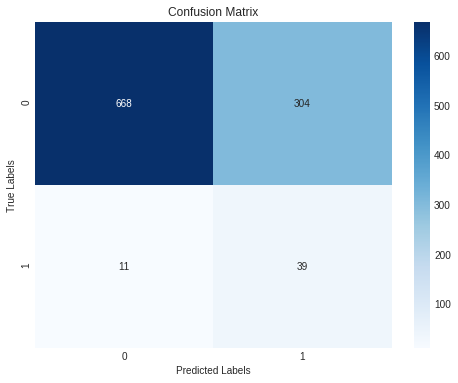

[[668 304]
 [ 11  39]]


In [74]:
# Make predictions
predictions = rf_pipeline.predict(X_test)

# evaluate the predictions
accuracy = accuracy_score(y_test, predictions)
print(f"Model Accuracy: {accuracy}")
print(classification_report(y_test, predictions))
print("\n\n")

conf_matrix = confusion_matrix(y_test, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

print(conf_matrix)

### Interpreting the Results

#### Accuracy (69.18%)
The model makes accurate predictions 69.18% of the time. A further decrease in accuracy implies that the model is generalising results a bit more. To understand what this means for the goal of predicting a stroke, it requires us to look at the results for each class.

#### Class 0 (No Stroke) - no real change
- Precision (98%): 98% of events predicted as class 0 are actually class 0, this is a slight increase on previous results
- Recall (69%): The model identified 69% of actual events of class 0, a decrease on previous results which indicates an increase in false positives.
- F1-Score (81%): For class 0 the F1-score indicates a good balance between precision and recall, even if it has decreased somewhat.

#### Class 1 (Stroke) - slight change
- Precision (11%): The model is not able to predict class 1 events with a high degree of accuracy. The result indicates that 89% of the events predicted as class 1 events are false positives
- Recall (78%%): Of the total possible predicted class 1 events, the model predicted 78% of them accurately (this is a welcomed improvement on previous results). The result tells us that 22% of the possible correct predictions are false negatives. The model has improved in its ability to identify true positive greatly, and reduced the number of false negatives. The model is close to becoming usable.
- F1-Score (20%): For class 1 the F1-Score indicates the poor performance of precision and recall, though better than previously performed.

#### Confusion Matrix
The confusion matrix [668, 304], [11, 39] can be interpreted as follows:

- True Negative (TN = 668): The model correctly predicted the negative class (class 0) 668 times.
- False Positive (FP = 304): The model incorrectly predicted the positive class (class 1) 304 times when it was actually class 0.
- False Negative (FN = 11): The model incorrectly predicted the negative class 11 times when it was actually class 1.
- True Positive (TP = 39): The model correctly predicted the positive class only 39 times.


#### Interpretation and Considerations
- Imbalanced Dataset: class weighting remained the same, and the SMOTE settings were also maintained in order to assess the benefits of the transformation and standardisation of the data.
- Class 1 Performance: The recall and F1-score for class 1 suggests the model is improving in its ability to correctly identify positive cases. The F1-score will remain low though as the number of false positives increased
- Model Bias: The model is maintaining a bias to the majority class, however the number of true positives is increasing, this is a positive move forward for the model.
- Improvements and Next Steps: 
    - Feature engineering succeeded again in providing better results from the model. Feature engineering could be considered complete unless another model requires some transformation, however, having scaled the data and ensuring all the data is numeric means the data is now suitably represented to provide an input into most models.
    - hyperparameters of the Random Forest can be tuned effectively now.
    - Other models can be tested.

## Data Transformations and Feature Engineering Summary

The random forest served as the baseline model while feature engineering and data transformations were made and tested. The first part of this paper has focused heavily on ensuring the features provided to the model can enhance the model performance without any significant parameter tuning. The following actions proved to greatly enhance the abilities of the model to predict a stroke.

The baseline prediction had a class 0 recall of 100% and a class 1 recall of 2%, with an overall model accuracy of 95%. However, with imbalanced data sets, it is absolutely critical to look into improving the accuracy of the imbalanced class, i.e. events where a stroke took place. Further, considering the medical nature and the high cost of missing a stroke prediction, it is even more critical to reduce the number of false negatives, while false positives can, up to a point, be permitted in the model predictions.

By the end of the feature engineering and data transformations, the following preprocessing was prepared for the data:
- drop the id column
- use a median imputer to fill the missing values in bmi, as the missing values are ~5% of the dataset a more complex imputer was not tested or needed. Imputing is however necessary in order to not drop data in a live system.
- batched age, bmi, and avg_glucose_level according to common, or medically approved boundaries to determine categorical values
- one hot encoded categories in order to convert them to numerical values
- bmi was transformed using a log transformation which normalised the skewed data
- continuous variables were scaled using a standard scaler which scales the data to variance from the mean, which is centered at 0. Doing so ensures all features can be considered on the same scale, which is important for machine learning models in order to reduce bias of feature importance.
- class imbalance was addressed with a SMOTE rebalancing of the minority class
- class weighting was also introduced in the model, though this was part of checking and improving a baseline model before tuning the parameter

The results of the model improved during the process of testing the transformations and engineering. The final model before focusing on model parameters and cross validation produced a great improvement from the baseline prediction. The final prediction had a class 0 recall of 69% and a class 1 recall of 78%, with an overall model accuracy of 69%.

The decrease in accuracy is expected as the model needs to generalise in order to make predictions, though it should not favour any class. The reduction in class 0 bias, resulted in lower false negatives, which is good for the purpose of the model, higher true positives which is the significant metric of measurement for the performance of the model, and increased false positives which is acceptable in this case.

### Possible Improvements

- More data of class 1 could significantly help in training the model to be more accurate in predicting strokes
- Dimensionality reduction could be tested to check if features can be dropped
- More scientific health and lifestyle scores could be researched and applied
- Refinement of features such as work type could indicate whether it is a high manual labour job or sedentary job



## HyperParameters and CrossValidation

Tuning the hyperparameters of the model can help the model become more accurate. There are tools that can be used to assist with parameter tuning such as RandomSearch etc. which will go through some parameters and try and find the best results, there is also the cross validation process to be used on the model to ensure it is producing reliable results.

From here on, the CustomProcessor will remain the same until a change is required.

Running Cross Validation can be compute heavy, therefore, the iterations will be kept to 20 and the validation folds to 3 for now to give an idea of what is needed. The parameters will be set at logical and apparent intervals as a first attempt.
An important aspect of the cross validation is the scoring metric. As the data is a binary classification the binary scorer will be used.

In [75]:
# reproduce the split of data
# Prepare data for modelling with the new features

# Declare the feature and target datasets
X = df.drop(['id', 'stroke'], axis=1)
y = df['stroke']

# split the data using the exact same split we assessed before - hence the random seed being set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42, stratify=y)

In [76]:
# Define the parameter grid
param_dist = {
    # RandomForest parameters
    'classifier__n_estimators': [100, 200, 300, 400, 500], # Number of trees
    'classifier__max_depth': [10, 20, 30, 40, 50, None], # Controls the max depth of each tree, None allows arbitrary growth
    'classifier__min_samples_split': [2, 5, 10], # The minimum number of samples required to split a node, reduces overfitting
    'classifier__min_samples_leaf': [1, 2, 4], # Controls the number of nodes required for a leaf to exist, controls leaf size and data smoothing
    'classifier__bootstrap': [True, False], # When True, allows sampling replacement, when False, the whole dataset is used for each tree
    'classifier__class_weight': [{0:1, 1:5},{0:1, 1:10},{0:1, 1:15},{0:1, 1:20}, 'balanced', 'balanced_subsample'], # Multiple weighting categories to try, balanced does the inverse to class frequencies, and 
                                                                                                                   # balanced_subsample is computed based on the subsample of data for the tree
    # SMOTE parameters
    'smote__k_neighbors': [1, 2, 3, 5, 10]  # Different values for k_neighbors
}

# Re-Initiate an instance of the RandomForestClassifier with the same starting default values - 100 trees, and a max depth for the trees set to 11 for the number of original features
# maintain the class_weight parameter in the random forest
weights = {0:1, 1:10}
rf_model = RandomForestClassifier(random_state=42)

rf_pipeline = ImbPipeline(steps=[
    ('preprocessor', CustomPreprocessor()),             # custom preprocessing and feature engineering
    ('smote', SMOTE()),                         # SMOTE for handling class imbalance
    ('classifier', rf_model)    # Random Forest classifier
])

f1_scorer_macro = make_scorer(f1_score, average='binary')  # For averaging F1 scores across all classes equally


Rerunning the models produced slightly different results, increasing cross validation from 3 to 10

In [77]:
# Random search of parameters
rf_random = RandomizedSearchCV(estimator=rf_pipeline, param_distributions=param_dist,
                               n_iter=100, cv=10, verbose=2, random_state=42, n_jobs=-1, scoring=f1_scorer_macro)

In [78]:
rf_random.fit(X_train, y_train)

# Extract results
results = rf_random.cv_results_
simplified_results = []

for i in range(len(results['rank_test_score'])):
    iteration_result = {
        'Rank': results['rank_test_score'][i],
        'Parameters': results['params'][i],
        'Mean Test Score': results['mean_test_score'][i],
        'Std Test Score': results['std_test_score'][i]
    }
    simplified_results.append(iteration_result)

# Best parameters
print("Best Parameters: ", rf_random.best_params_)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best Parameters:  {'smote__k_neighbors': 2, 'classifier__n_estimators': 100, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 4, 'classifier__max_depth': 20, 'classifier__class_weight': {0: 1, 1: 20}, 'classifier__bootstrap': True}


In [79]:
rf_random.cv_results_

{'mean_fit_time': array([6.53154221, 6.51979854, 3.05860744, 4.23938215, 6.68462844,
        4.84546466, 5.10569024, 3.45923259, 2.10206528, 3.70894275,
        4.4152499 , 1.20002873, 1.18059404, 0.97438719, 6.98161197,
        4.47644758, 4.88408456, 4.47690146, 6.80862987, 5.47588377,
        3.15887794, 5.34578028, 4.46702399, 3.3307013 , 1.49310665,
        6.95469415, 6.05082178, 2.24265649, 3.37844658, 1.23681664,
        4.72607026, 2.30919235, 2.26737785, 3.35562336, 2.44420741,
        4.88030605, 4.31544387, 7.61737237, 6.38396001, 6.09588244,
        8.37183552, 2.41397583, 7.08162892, 6.3323945 , 4.14349179,
        4.56881621, 5.95543342, 8.32629054, 2.90065904, 5.49519963,
        2.08691127, 2.35214944, 2.44791598, 6.03621943, 2.93540885,
        4.53871229, 5.60564787, 1.07038369, 6.79124522, 2.32582645,
        4.60812132, 4.87772233, 2.77390914, 3.09022193, 1.50490215,
        4.70182562, 1.75095241, 6.40338497, 3.06270895, 1.76939659,
        3.16855581, 3.36972861,

In [80]:
# Assess top 30 scores
top_scores = sorted(rf_random.cv_results_['mean_test_score'], reverse=True)[:30]
top_indices = [list(rf_random.cv_results_['mean_test_score']).index(score) for score in top_scores]
top_params = [rf_random.cv_results_['params'][i] for i in top_indices]
recall_results = []

for i, params in enumerate(top_params):
    
    # split the data using the exact same split we assessed before - hence the random seed being set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42, stratify=y)
    
    # Set the pipeline with the current parameters
    rf_pipeline.set_params(**params)
    
    # Perform cross-validated predictions
    y_pred = cross_val_predict(rf_pipeline, X_train, y_train, cv=10, method='predict')
    
    # Calculate recall for class 1
    recall_class1 = recall_score(y_train, y_pred, pos_label=1)
    # Calculate recall for class 0
    recall_class0 = recall_score(y_train, y_pred, pos_label=0)
    
    # Store results
    iteration_result = {
        'rank': results['rank_test_score'][i],
        'parameters': params,
        'mean_test': results['mean_test_score'][i],
        'std_test': results['std_test_score'][i],
        'recall_class1': recall_class1,
        'recall_class0': recall_class0
    }
    recall_results.append(iteration_result)

In [81]:
top_recall_class1_params = []

for result in recall_results:
    rank = result.get('rank')
    params = result.get('parameters')
    mean_score = result.get('mean_test')
    std_test = result.get('std_test')
    recall_class1 = result.get('recall_class1')
    recall_class0 = result.get('recall_class0')
    
    print(f"rank: {rank}\nparams: {params}\nmean score: {mean_score}\nstd test: {std_test}\nrecall class 1: {recall_class1}\nrecall class 0: {recall_class0}")
    
    if recall_class1 > 0.80:
        top_recall_class1_params.append(params)
    

rank: 99
params: {'smote__k_neighbors': 2, 'classifier__n_estimators': 100, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 4, 'classifier__max_depth': 20, 'classifier__class_weight': {0: 1, 1: 20}, 'classifier__bootstrap': True}
mean score: 0.08281746031746032
std test: 0.07803188993956678
recall class 1: 0.4824120603015075
recall class 0: 0.8282334790434559
rank: 100
params: {'smote__k_neighbors': 2, 'classifier__n_estimators': 300, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 2, 'classifier__max_depth': 10, 'classifier__class_weight': 'balanced', 'classifier__bootstrap': True}
mean score: 0.07525071225071225
std test: 0.06681396546593099
recall class 1: 0.4020100502512563
recall class 0: 0.868603754178452
rank: 19
params: {'smote__k_neighbors': 5, 'classifier__n_estimators': 200, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 4, 'classifier__max_depth': 50, 'classifier__class_weight': {0: 1, 1: 10}, 'classifier__bootstr

From viewing the result of the cross validation tests on the training data, the top parameters for maximising recall on class 1 events can be seen. For testing, these are all events which provided a recall score higher than 80% on class 1. These parameters will be tested on the test data.

In [82]:
top_recall_class1_params

[{'smote__k_neighbors': 1,
  'classifier__n_estimators': 500,
  'classifier__min_samples_split': 10,
  'classifier__min_samples_leaf': 4,
  'classifier__max_depth': 10,
  'classifier__class_weight': {0: 1, 1: 10},
  'classifier__bootstrap': False},
 {'smote__k_neighbors': 1,
  'classifier__n_estimators': 200,
  'classifier__min_samples_split': 5,
  'classifier__min_samples_leaf': 2,
  'classifier__max_depth': 10,
  'classifier__class_weight': {0: 1, 1: 10},
  'classifier__bootstrap': False},
 {'smote__k_neighbors': 5,
  'classifier__n_estimators': 100,
  'classifier__min_samples_split': 5,
  'classifier__min_samples_leaf': 4,
  'classifier__max_depth': 10,
  'classifier__class_weight': {0: 1, 1: 10},
  'classifier__bootstrap': True},
 {'smote__k_neighbors': 2,
  'classifier__n_estimators': 400,
  'classifier__min_samples_split': 10,
  'classifier__min_samples_leaf': 4,
  'classifier__max_depth': 10,
  'classifier__class_weight': {0: 1, 1: 15},
  'classifier__bootstrap': False},
 {'smot

Parameters: {'smote__k_neighbors': 1, 'classifier__n_estimators': 500, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 4, 'classifier__max_depth': 10, 'classifier__class_weight': {0: 1, 1: 10}, 'classifier__bootstrap': False}
Model Accuracy: 0.6692759295499021
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       972
           1       0.11      0.84      0.20        50

    accuracy                           0.67      1022
   macro avg       0.55      0.75      0.50      1022
weighted avg       0.94      0.67      0.76      1022






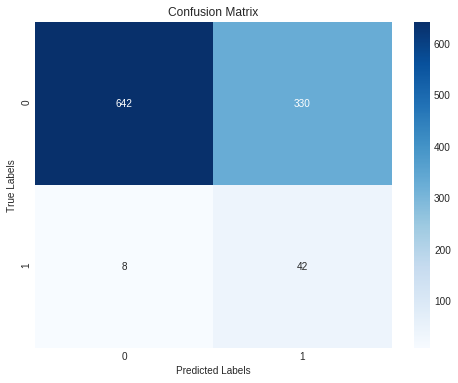

[[642 330]
 [  8  42]]



Parameters: {'smote__k_neighbors': 1, 'classifier__n_estimators': 200, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 2, 'classifier__max_depth': 10, 'classifier__class_weight': {0: 1, 1: 10}, 'classifier__bootstrap': False}
Model Accuracy: 0.6731898238747553
              precision    recall  f1-score   support

           0       0.99      0.67      0.79       972
           1       0.11      0.82      0.20        50

    accuracy                           0.67      1022
   macro avg       0.55      0.74      0.50      1022
weighted avg       0.94      0.67      0.77      1022






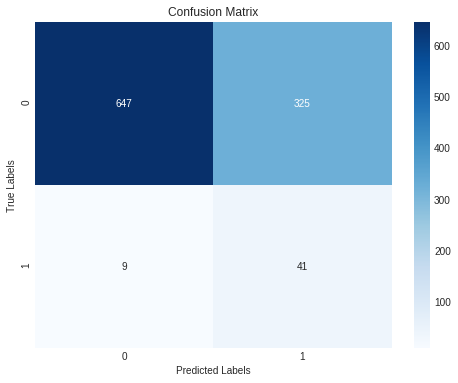

[[647 325]
 [  9  41]]



Parameters: {'smote__k_neighbors': 5, 'classifier__n_estimators': 100, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 4, 'classifier__max_depth': 10, 'classifier__class_weight': {0: 1, 1: 10}, 'classifier__bootstrap': True}
Model Accuracy: 0.6448140900195695
              precision    recall  f1-score   support

           0       0.99      0.63      0.77       972
           1       0.11      0.84      0.19        50

    accuracy                           0.64      1022
   macro avg       0.55      0.74      0.48      1022
weighted avg       0.94      0.64      0.74      1022






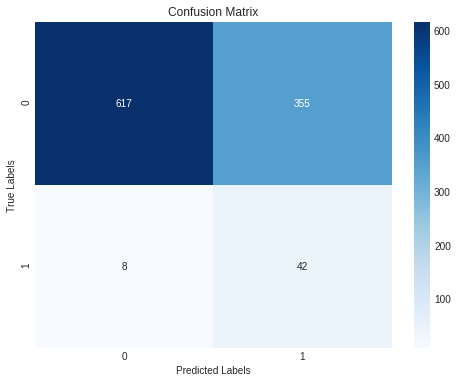

[[617 355]
 [  8  42]]



Parameters: {'smote__k_neighbors': 2, 'classifier__n_estimators': 400, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 4, 'classifier__max_depth': 10, 'classifier__class_weight': {0: 1, 1: 15}, 'classifier__bootstrap': False}
Model Accuracy: 0.639921722113503
              precision    recall  f1-score   support

           0       0.99      0.63      0.77       972
           1       0.10      0.84      0.19        50

    accuracy                           0.64      1022
   macro avg       0.55      0.73      0.48      1022
weighted avg       0.94      0.64      0.74      1022






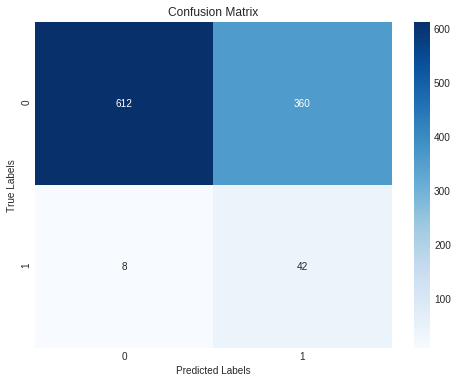

[[612 360]
 [  8  42]]



Parameters: {'smote__k_neighbors': 3, 'classifier__n_estimators': 500, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 1, 'classifier__max_depth': 10, 'classifier__class_weight': {0: 1, 1: 15}, 'classifier__bootstrap': True}
Model Accuracy: 0.649706457925636
              precision    recall  f1-score   support

           0       0.99      0.64      0.78       972
           1       0.11      0.84      0.19        50

    accuracy                           0.65      1022
   macro avg       0.55      0.74      0.48      1022
weighted avg       0.94      0.65      0.75      1022






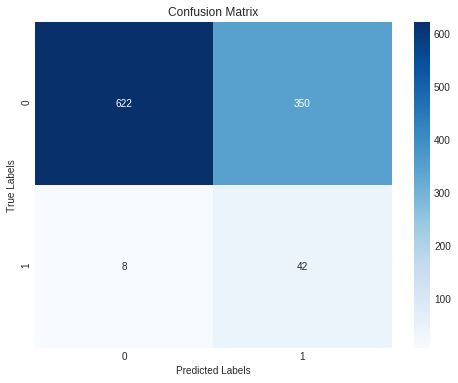

[[622 350]
 [  8  42]]



Parameters: {'smote__k_neighbors': 10, 'classifier__n_estimators': 200, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 1, 'classifier__max_depth': 10, 'classifier__class_weight': {0: 1, 1: 15}, 'classifier__bootstrap': True}
Model Accuracy: 0.6438356164383562
              precision    recall  f1-score   support

           0       0.99      0.63      0.77       972
           1       0.11      0.84      0.19        50

    accuracy                           0.64      1022
   macro avg       0.55      0.74      0.48      1022
weighted avg       0.94      0.64      0.74      1022






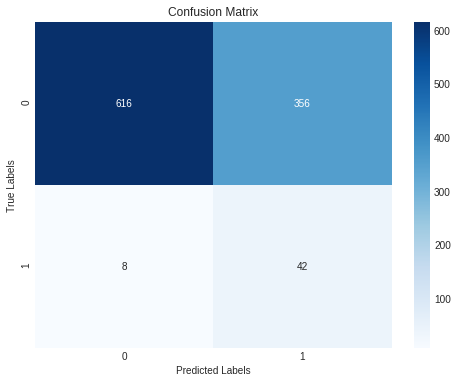

[[616 356]
 [  8  42]]



Parameters: {'smote__k_neighbors': 1, 'classifier__n_estimators': 200, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 1, 'classifier__max_depth': 10, 'classifier__class_weight': {0: 1, 1: 15}, 'classifier__bootstrap': False}
Model Accuracy: 0.649706457925636
              precision    recall  f1-score   support

           0       0.99      0.64      0.78       972
           1       0.11      0.84      0.19        50

    accuracy                           0.65      1022
   macro avg       0.55      0.74      0.48      1022
weighted avg       0.94      0.65      0.75      1022






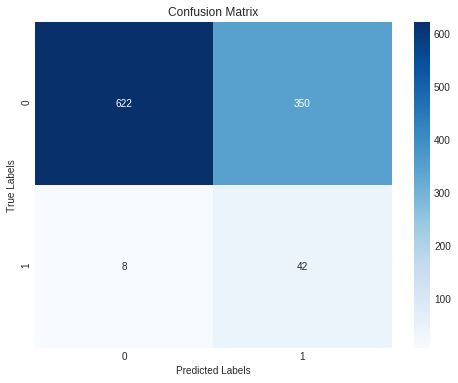

[[622 350]
 [  8  42]]



Parameters: {'smote__k_neighbors': 2, 'classifier__n_estimators': 200, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 1, 'classifier__max_depth': 10, 'classifier__class_weight': {0: 1, 1: 20}, 'classifier__bootstrap': False}
Model Accuracy: 0.6301369863013698
              precision    recall  f1-score   support

           0       0.99      0.62      0.76       972
           1       0.10      0.86      0.19        50

    accuracy                           0.63      1022
   macro avg       0.55      0.74      0.47      1022
weighted avg       0.95      0.63      0.73      1022






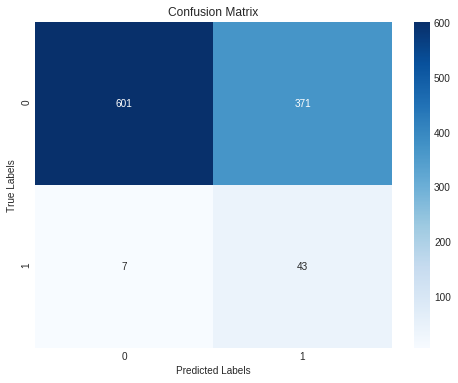

[[601 371]
 [  7  43]]



Parameters: {'smote__k_neighbors': 10, 'classifier__n_estimators': 200, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 4, 'classifier__max_depth': 10, 'classifier__class_weight': {0: 1, 1: 20}, 'classifier__bootstrap': False}
Model Accuracy: 0.6056751467710372
              precision    recall  f1-score   support

           0       0.99      0.59      0.74       972
           1       0.10      0.86      0.18        50

    accuracy                           0.61      1022
   macro avg       0.54      0.73      0.46      1022
weighted avg       0.94      0.61      0.71      1022






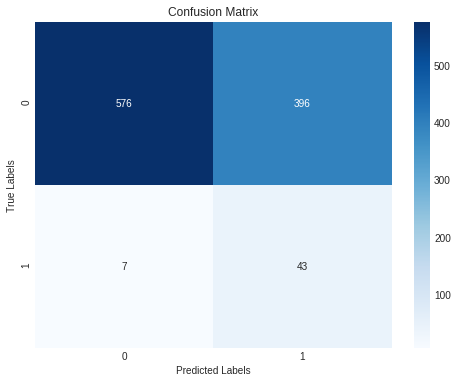

[[576 396]
 [  7  43]]





In [83]:
# Analyzing top recall parameters
for params in top_recall_class1_params:
    
    # split the data using the exact same split we assessed before - hence the random seed being set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42, stratify=y)
    
    
    # Set the pipeline with these parameters
    rf_pipeline.set_params(**params)
    rf_pipeline.fit(X_train, y_train)
    
    # Predict and generate confusion matrix
    predictions = rf_pipeline.predict(X_test)
    
    print(f"Parameters: {params}")
    
    # evaluate the predictions
    accuracy = accuracy_score(y_test, predictions)
    print(f"Model Accuracy: {accuracy}")
    print(classification_report(y_test, predictions))
    print("\n\n")

    conf_matrix = confusion_matrix(y_test, predictions)

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    print(conf_matrix)
    
    print(f"\n\n")

## Random Forest Parameter Tuning and Cross Validation Summary

To tune and validate the model, a Random Search grid was selected due to its ease of implementation, practicality, efficient use of resources and reliable results. The parameters to which the search covered effect the model in the following ways:
- classifier__n_estimators: Number of trees
- classifier__min_samples_split: The minimum number of samples required to split a node, reduces overfitting
- classifier__min_samples_leaf: Controls the number of nodes required for a leaf to exist, controls leaf size and data smoothing
- classifier__max_depth: Determines the maximum depth of each tree in the ensemble
- classifier__class_weight: Multiple weighting categories to try, balanced does the inverse to class frequencies, and balanced_subsample is computed based on the subsample of data for the tree
- classifier__bootstrap: When True, allows sampling replacement, when False, the whole dataset is used for each tree
- smote__k_neighbors: Different values for k_neighbors

The cross validation parameters were set to allow a large number of models to run with 100 iterations running 10 folds, which is 1000 models in total and the scores were averaged using a binary f1 scorer which accounts for the data type.

The results of the cross validation were over 100 possible parameter configurations for the model of varying degrees of accuracy, however, knowing that accuracy is not the best result to measure an imbalanced dataset, the top 30 results were chosen and the models run again while recording the class 0 and class 1 recall and other scores.

After running through the top 30 models, and filtering the results for the best recall based on the event occurring it is found that the best parameters for the model are different to the original best parameters provided by the score in cross validation. 

These set of parameters that produce the lowest number of false negatives so far, capturing 88% of the positive cases truthfully. the model still reports a relatively high number of false positives, capturing 59% of the negative cases correctly on the training data. This is useful information, in the sense that it provides an indication of those at risk of a stroke, and it is always better to err on the side of safety where medical prognoses are concerned.

The original choice of the best parameters of the model does not align with the knowledge of the data and what is needed for the model to succeed in a live environment. The true best fit for the scenario and data is the following parameters:

{'smote__k_neighbors': 10, 'classifier__n_estimators': 200, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 4, 'classifier__max_depth': 10, 'classifier__class_weight': {0: 1, 1: 20}, 'classifier__bootstrap': False}

When tested on the test data, the model with the above parameters had the following performance:
- f1-score class 1: 86%, only 14% of true positive events were reported as false negatives which is quite a good result for the test data, this shows that the model is not overfitting to the positive events, as the result is similar to the training result.
- f1-score class 0: 59%, exactly the same as training, 41% of the total true negative events were actually labelled as positive events, the amount of false positives is steady between training and testing, which indicates that the model has trained well and is not over or under fitting on the data.


# Gradient Boosted Classifier

The next choice of model is to train a gradient boosted classifier to make the classifications. 

A gradient boosted classifier is an extension of the ensemble method followed in a random forest, where predictors are added to the ensemble and each one corrects its predecessor. It does this by fitting a new predictor to the residual errors made by the previous predictor (Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 3rd Edition, by Aurélien Géron). As the gradient booster uses the same methods as a tree classifier, decision tree or random forest, this can be seen as an extension of the random forest and the work performed earlier.



### Establish a baseline

The data engineering preprocessing will be maintained, however, it is important to establish a baseline on the orginal data. For consistency, the same basic transformations (imputing bmi and one hot encoding categorical features) will be made for the baseline model, then the improved data transformations can be tested. Once the data transformations have been tested on the baseline model, the decision will be made on which data to use to tune the parameters of the model.

In [9]:
# reproduce the split of data

# Declare the feature and target datasets
X = df.drop(['id', 'stroke'], axis=1)
y = df['stroke']

# split the data using the exact same split we assessed before - hence the random seed being set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42, stratify=y)

In [90]:
# The original baseline transformation pipeline is used

# create bmi pipeline
baseline_bmi_pipeline = make_pipeline(SimpleImputer(strategy='median')
                                     )


# one hot encode categorical data
baseline_categorical_transformer = make_pipeline(OneHotEncoder()
                                                )

# baseline preprocessing pipeline
baseline_preprocess_pipeline = ColumnTransformer(
    transformers = [
    ('bmi_pipeline', baseline_bmi_pipeline, ['bmi']),
    ('one_hot_encoder', baseline_categorical_transformer, ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'])
    ],
    remainder='passthrough'
)

In [91]:
# Initiate an instance of the RandomForestClassifier with some starting default values
gb_clf = GradientBoostingClassifier(random_state=42)

baseline_full_pipeline = Pipeline(steps=[
                                    ('preprocessor', baseline_preprocess_pipeline),
                                    ('classifier', gb_clf)
                                ])


baseline_full_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('bmi_pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['bmi']),
                                                 ('one_hot_encoder',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder())]),
                                                  ['gender', 'ever_married',
                                                   'work_type',
                                                   'Residence_type',
                                                   'smoking_status'])])),
                ('classifier', GradientBoostingClassifier(random_stat

Model Accuracy: 0.9510763209393346
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.50      0.04      0.07        50

    accuracy                           0.95      1022
   macro avg       0.73      0.52      0.52      1022
weighted avg       0.93      0.95      0.93      1022






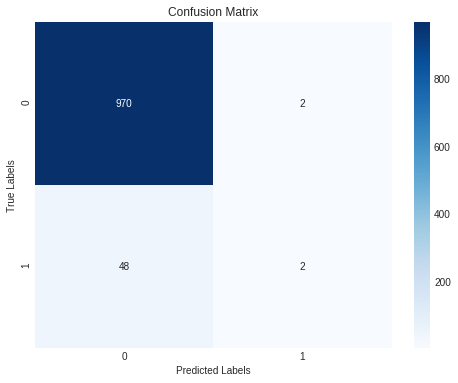

[[970   2]
 [ 48   2]]





In [92]:
predictions = baseline_full_pipeline.predict(X_test)

# evaluate the predictions
accuracy = accuracy_score(y_test, predictions)
print(f"Model Accuracy: {accuracy}")
print(classification_report(y_test, predictions))
print("\n\n")

conf_matrix = confusion_matrix(y_test, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

print(conf_matrix)

print(f"\n\n")

### Summary and Interpretation

The baseline for the Gradient Boosted Classifier showed a slight improvement in the true positive results compared to the random forest. Though on the whole the results are very similar to the baseline Random Forest Classifier which is expected due to the underlying model of the gradient booster being tree based.

Next step will be to train the model on the transformed data and assess the difference.

In [102]:
# instantiate smote
smote = SMOTE(k_neighbors=3, random_state=42)

gb_pipeline = ImbPipeline(steps=[
    ('preprocessor', CustomPreprocessor()),             # custom preprocessing and feature engineering
    ('smote', smote),                         # SMOTE for handling class imbalance
    ('classifier', gb_clf)    # The baseline Gradient Boosted model
])

# train and predict the model
gb_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor', CustomPreprocessor()),
                ('smote', SMOTE(k_neighbors=3, random_state=42)),
                ('classifier', GradientBoostingClassifier(random_state=42))])

Model Accuracy: 0.7348336594911937
              precision    recall  f1-score   support

           0       0.98      0.74      0.84       972
           1       0.12      0.70      0.21        50

    accuracy                           0.73      1022
   macro avg       0.55      0.72      0.52      1022
weighted avg       0.94      0.73      0.81      1022






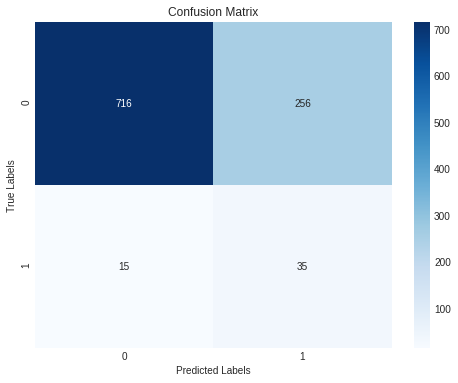

[[716 256]
 [ 15  35]]





In [103]:
predictions = gb_pipeline.predict(X_test)

# evaluate the predictions
accuracy = accuracy_score(y_test, predictions)
print(f"Model Accuracy: {accuracy}")
print(classification_report(y_test, predictions))
print("\n\n")

conf_matrix = confusion_matrix(y_test, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

print(conf_matrix)

print(f"\n\n")

### Random Forest vs Gradient Boosted Results After Transformation

#### Random Forest

- Accuracy 69.18%

- Class 0 Precision 98%
- Class 0 Recall 69%
- Class 0 F1-Score 81%

- Class 1 Precision 11%
- Class 1 Recall 78%
- Class 1 F1-Score 20%

Confusion Matrix
The confusion matrix [668, 304], [11, 39] can be interpreted as follows:

True Negative (TN = 772): The model correctly predicted the negative class (class 0) 772 times.
False Positive (FP = 304): The model incorrectly predicted the positive class (class 1) 304 times when it was actually class 0.
False Negative (FN = 11): The model incorrectly predicted the negative class 11 times when it was actually class 1.
True Positive (TP = 39): The model correctly predicted the positive class only 39 times.

#### Gradient Boosted Classifier

- Accuracy 73.48%

- Class 0 Precision 98%
- Class 0 Recall 74%
- Class 0 F1-Score 84%

- Class 1 Precision 12%
- Class 1 Recall 70%
- Class 1 F1-Score 21%

Confusion Matrix
The confusion matrix [716, 256], [15, 35] can be interpreted as follows:

- True Negative (TN = 716): The model correctly predicted the negative class (class 0) 716 times.
- False Positive (FP = 256): The model incorrectly predicted the positive class (class 1) 256 times when it was actually class 0.
- False Negative (FN = 15): The model incorrectly predicted the negative class 15 times when it was actually class 1.
- True Positive (TP = 35): The model correctly predicted the positive class only 35 times.

#### Summary

The transformations and feature engineering made a substantial improvement on the model. Compared to the Random Forest Classifier the Gradient Boosted Classifier provided slightly less true positives, 78% to 70% respectively, this is not a very substantial margin and when it is considered that the model provided significantly less false positives, it is beginning to look like the Gradient Boosted model may provide a slightly better balanced model and not over fit to the negative class, while maintaining a high degree of accuracy for the positive class.

## HyperParameters and CrossValidation

The parameters when tuning and validating the Random forest will be used to assist with tuning the Gradient Boosted Classifier. Some notes on the changes:
- learning rate effects the gradient boosted model learning abilities (how much of a correction it can make from the predecessor)
- class weights is not a viable parameter in a gradient boosted model as the model learns the weights itself
- subsample effects how much of the data is sampled in each ensemble level, it can help to control overfitting

In [104]:
# Define the parameter grid
param_dist = {
    # Gradient Boosting parameters
    'classifier__n_estimators': [100, 200, 300, 400, 500],  # Number of trees
    'classifier__max_depth': [3, 4, 5, 6, 7, None],  # Max depth of each tree
    'classifier__min_samples_split': [2, 5, 10],  # Min samples to split a node
    'classifier__min_samples_leaf': [1, 2, 4],  # Min samples at a leaf node
    'classifier__learning_rate': [0.01, 0.1, 0.2, 0.5],  # Learning rate
    'classifier__subsample': [0.8, 0.9, 1.0],  # The fraction of samples to be used for fitting individual base learners

    # SMOTE parameters
    'smote__k_neighbors': [1, 2, 3, 5, 10]  # Values for k_neighbors in SMOTE
}

# Initiate an instance of the RandomForestClassifier with some starting default values
gb_clf = GradientBoostingClassifier(random_state=42)

gb_pipeline = ImbPipeline(steps=[
    ('preprocessor', CustomPreprocessor()),             # custom preprocessing and feature engineering
    ('smote', SMOTE()),                         # SMOTE for handling class imbalance
    ('classifier', gb_clf)    # Gradient Boosted Classifier
])

f1_scorer_macro = make_scorer(f1_score, average='binary')  # For averaging F1 scores across all classes equally

In [105]:
# Random search of parameters
gb_random = RandomizedSearchCV(estimator=gb_pipeline, param_distributions=param_dist,
                               n_iter=100, cv=10, verbose=2, random_state=42, n_jobs=-1, scoring=f1_scorer_macro)

In [106]:
gb_random.fit(X_train, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('preprocessor',
                                              CustomPreprocessor()),
                                             ('smote', SMOTE()),
                                             ('classifier',
                                              GradientBoostingClassifier(random_state=42))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'classifier__learning_rate': [0.01, 0.1,
                                                                      0.2,
                                                                      0.5],
                                        'classifier__max_depth': [3, 4, 5, 6, 7,
                                                                  None],
                                        'classifier__min_samples_leaf': [1, 2,
                                                                         4],
                                        

In [ ]:
# Extract results
results = gb_random.cv_results_
simplified_results = []

for i in range(len(results['rank_test_score'])):
    iteration_result = {
        'Rank': results['rank_test_score'][i],
        'Parameters': results['params'][i],
        'Mean Test Score': results['mean_test_score'][i],
        'Std Test Score': results['std_test_score'][i]
    }
    simplified_results.append(iteration_result)

# Best parameters
print("Best Parameters: ", gb_random.best_params_)

In [107]:
# Assess top 30 scores
top_scores = sorted(gb_random.cv_results_['mean_test_score'], reverse=True)[:30]
top_indices = [list(gb_random.cv_results_['mean_test_score']).index(score) for score in top_scores]
top_params = [gb_random.cv_results_['params'][i] for i in top_indices]
recall_results = []

for i, params in enumerate(top_params):
    
    # split the data using the exact same split we assessed before - hence the random seed being set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42, stratify=y)
    
    # Set the pipeline with the current parameters
    gb_pipeline.set_params(**params)
    
    # Perform cross-validated predictions
    y_pred = cross_val_predict(gb_pipeline, X_train, y_train, cv=10, method='predict')
    
    # Calculate recall for class 1
    recall_class1 = recall_score(y_train, y_pred, pos_label=1)
    # Calculate recall for class 0
    recall_class0 = recall_score(y_train, y_pred, pos_label=0)
    
    # Store results
    iteration_result = {
        'rank': results['rank_test_score'][i],
        'parameters': params,
        'mean_test': results['mean_test_score'][i],
        'std_test': results['std_test_score'][i],
        'recall_class1': recall_class1,
        'recall_class0': recall_class0
    }
    recall_results.append(iteration_result)

In [110]:
top_recall_class1_params = []

for result in recall_results:
    rank = result.get('rank')
    params = result.get('parameters')
    mean_score = result.get('mean_test')
    std_test = result.get('std_test')
    recall_class1 = result.get('recall_class1')
    recall_class0 = result.get('recall_class0')
    
    print(f"rank: {rank}\nparams: {params}\nmean score: {mean_score}\nstd test: {std_test}\nrecall class 1: {recall_class1}\nrecall class 0: {recall_class0}")
    
    if recall_class1 > 0.80:
        top_recall_class1_params.append(params)

rank: 99
params: {'smote__k_neighbors': 10, 'classifier__subsample': 0.9, 'classifier__n_estimators': 300, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 1, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.01}
mean score: 0.08281746031746032
std test: 0.07803188993956678
recall class 1: 0.7487437185929648
recall class 0: 0.7462072512213936
rank: 100
params: {'smote__k_neighbors': 5, 'classifier__subsample': 1.0, 'classifier__n_estimators': 200, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 1, 'classifier__max_depth': 5, 'classifier__learning_rate': 0.01}
mean score: 0.07525071225071225
std test: 0.06681396546593099
recall class 1: 0.678391959798995
recall class 0: 0.7372075083569041
rank: 19
params: {'smote__k_neighbors': 10, 'classifier__subsample': 0.8, 'classifier__n_estimators': 200, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 1, 'classifier__max_depth': 4, 'classifier__learning_rate': 0.01}
mean score: 

### Gradient Boosting Parameter Tuning Summary First Round

None of the models reached the threshhold score for recall of class 1 which was set. i.e. recall class 1 > 80%. There may be some adjustments needed in the cross validation. 

The number of folds = 10 can be reduced to 5 to ensure there is more data per fold, this allows for more data to be used when producing the model which corrects on its predecessor. This will also impact the computational cost, reducing the resources required and time taken to validate the model. The folding is not stratified due to the use of smote resampling.

When assessing how the model did previously, the following results were the best performing model when focused on recall for class 1.


- params: {'smote__k_neighbors': 10, 'classifier__subsample': 0.9, 'classifier__n_estimators': 300, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 1, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.01}
- mean score: 0.08281746031746032
- std test: 0.07803188993956678
- recall class 1: 0.7487437185929648
- recall class 0: 0.7462072512213936

The above parameters provide a good starting point and from here it looks like a wider range on some of the parameters may be required for the model to find the best parameters. The new parameters will also introduce a new parameter call max_features, which allow the model to look for a split of features on which to predict. This may enhance the model's ability to generalise.

In [16]:
param_dist_expanded = {
    'classifier__n_estimators': [100, 200, 300, 400, 500, 600, 700],  # Expanded range
    'classifier__learning_rate': [0.005, 0.01, 0.05, 0.1, 0.2],  # More options, including lower values
    'classifier__max_depth': [3, 4, 5, 6, 7, 8, 9, 10],  # Wider range
    'classifier__min_samples_split': [2, 5, 10, 15, 20],  # Wider range
    'classifier__min_samples_leaf': [1, 2, 4, 6, 8],  # Wider range
    'classifier__subsample': [0.7, 0.8, 0.9, 1.0],  # Including lower values
    'classifier__max_features': ['sqrt', 'log2', None, 0.7, 0.8, 0.9],  # New parameter
    'smote__k_neighbors': [5, 10, 15, 20, 25, 30]  # Wider range
}


# Initiate an instance of the RandomForestClassifier with some starting default values
gb_clf = GradientBoostingClassifier(random_state=42)

gb_pipeline = ImbPipeline(steps=[
    ('preprocessor', CustomPreprocessor()),             # custom preprocessing and feature engineering
    ('smote', SMOTE()),                         # SMOTE for handling class imbalance
    ('classifier', gb_clf)    # Gradient Boosted Classifier
])

f1_scorer_macro = make_scorer(f1_score, average='binary')

In [17]:
# Random search of parameters
gb_random = RandomizedSearchCV(estimator=gb_pipeline, param_distributions=param_dist_expanded,
                               n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1, scoring=f1_scorer_macro)

In [18]:
gb_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              CustomPreprocessor()),
                                             ('smote', SMOTE()),
                                             ('classifier',
                                              GradientBoostingClassifier(random_state=42))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'classifier__learning_rate': [0.005,
                                                                      0.01,
                                                                      0.05, 0.1,
                                                                      0.2],
                                        'classifier__max_depth': [3, 4, 5, 6, 7,
                                                                  8, 9, 10],
                                        'classifier__max_features': ['sqrt',
                                      

In [20]:
# Extract results
results = gb_random.cv_results_
simplified_results = []

for i in range(len(results['rank_test_score'])):
    iteration_result = {
        'Rank': results['rank_test_score'][i],
        'Parameters': results['params'][i],
        'Mean Test Score': results['mean_test_score'][i],
        'Std Test Score': results['std_test_score'][i]
    }
    simplified_results.append(iteration_result)

# Best parameters
print("Best Parameters: ", gb_random.best_params_)

Best Parameters:  {'smote__k_neighbors': 10, 'classifier__subsample': 0.9, 'classifier__n_estimators': 500, 'classifier__min_samples_split': 20, 'classifier__min_samples_leaf': 4, 'classifier__max_features': 'log2', 'classifier__max_depth': 3, 'classifier__learning_rate': 0.01}


In [21]:
# Assess top 50 scores
top_scores = sorted(gb_random.cv_results_['mean_test_score'], reverse=True)[:50]
top_indices = [list(gb_random.cv_results_['mean_test_score']).index(score) for score in top_scores]
top_params = [gb_random.cv_results_['params'][i] for i in top_indices]
recall_results = []

for i, params in enumerate(top_params):
    
    # split the data using the exact same split we assessed before - hence the random seed being set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42, stratify=y)
    
    # Set the pipeline with the current parameters
    gb_pipeline.set_params(**params)
    
    # Perform cross-validated predictions
    y_pred = cross_val_predict(gb_pipeline, X_train, y_train, cv=5, method='predict')
    
    # Calculate recall for class 1
    recall_class1 = recall_score(y_train, y_pred, pos_label=1)
    # Calculate recall for class 0
    recall_class0 = recall_score(y_train, y_pred, pos_label=0)
    
    # Store results
    iteration_result = {
        'rank': results['rank_test_score'][i],
        'parameters': params,
        'mean_test': results['mean_test_score'][i],
        'std_test': results['std_test_score'][i],
        'recall_class1': recall_class1,
        'recall_class0': recall_class0
    }
    recall_results.append(iteration_result)

In [22]:
# Identify the top models for predicting a class 1 event. Threshold requires 80% accuracy of class 1 predictions
top_recall_class1_params = []

for result in recall_results:
    rank = result.get('rank')
    params = result.get('parameters')
    mean_score = result.get('mean_test')
    std_test = result.get('std_test')
    recall_class1 = result.get('recall_class1')
    recall_class0 = result.get('recall_class0')
    
    print(f"rank: {rank}\nparams: {params}\nmean score: {mean_score}\nstd test: {std_test}\nrecall class 1: {recall_class1}\nrecall class 0: {recall_class0}")
    
    if recall_class1 > 0.80:
        top_recall_class1_params.append(params)
        
        


rank: 17
params: {'smote__k_neighbors': 10, 'classifier__subsample': 0.9, 'classifier__n_estimators': 500, 'classifier__min_samples_split': 20, 'classifier__min_samples_leaf': 4, 'classifier__max_features': 'log2', 'classifier__max_depth': 3, 'classifier__learning_rate': 0.01}
mean score: 0.2042331272259851
std test: 0.009104691420033893
recall class 1: 0.5829145728643216
recall class 0: 0.805348418616611
rank: 56
params: {'smote__k_neighbors': 20, 'classifier__subsample': 0.7, 'classifier__n_estimators': 200, 'classifier__min_samples_split': 15, 'classifier__min_samples_leaf': 1, 'classifier__max_features': 0.7, 'classifier__max_depth': 4, 'classifier__learning_rate': 0.01}
mean score: 0.18593083782787714
std test: 0.026818009859137976
recall class 1: 0.5879396984924623
recall class 0: 0.8066340961686809
rank: 53
params: {'smote__k_neighbors': 5, 'classifier__subsample': 1.0, 'classifier__n_estimators': 100, 'classifier__min_samples_split': 20, 'classifier__min_samples_leaf': 2, 'clas

In [23]:
# Analyzing top recall parameters
for params in top_recall_class1_params:
    
    # split the data using the exact same split we assessed before - hence the random seed being set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42, stratify=y)
    
    
    # Set the pipeline with these parameters
    gb_pipeline.set_params(**params)
    gb_pipeline.fit(X_train, y_train)
    
    # Predict and generate confusion matrix
    predictions = gb_pipeline.predict(X_test)
    
    print(f"Parameters: {params}")
    
    # evaluate the predictions
    accuracy = accuracy_score(y_test, predictions)
    print(f"Model Accuracy: {accuracy}")
    print(classification_report(y_test, predictions))
    print("\n\n")

    conf_matrix = confusion_matrix(y_test, predictions)

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    print(conf_matrix)
    
    print(f"\n\n")

### Gradient Boosted Classifier Second Round

After the run of the new parameters, there was still no improvement found which could improve the class 1 score. The best performing model found so far is still a model with the following parameters:

{'smote__k_neighbors': 10, 'classifier__subsample': 0.9, 'classifier__n_estimators': 300, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 1, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.01}

Next steps are to analyse it and possibly manually change some parameters to test the effect.

Parameters: {'smote__k_neighbors': 10, 'classifier__subsample': 0.9, 'classifier__n_estimators': 300, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 1, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.01}
Model Accuracy: 0.7240704500978473
              precision    recall  f1-score   support

           0       0.98      0.72      0.83       972
           1       0.12      0.76      0.21        50

    accuracy                           0.72      1022
   macro avg       0.55      0.74      0.52      1022
weighted avg       0.94      0.72      0.80      1022






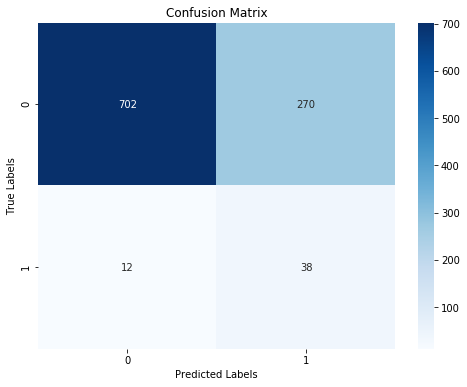

[[702 270]
 [ 12  38]]





In [26]:
# split the data using the exact same split we assessed before - hence the random seed being set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42, stratify=y)

params = {'smote__k_neighbors': 10, 
          'classifier__subsample': 0.9, 
          'classifier__n_estimators': 300, 
          'classifier__min_samples_split': 10, 
          'classifier__min_samples_leaf': 1, 
          'classifier__max_depth': 3, 
          'classifier__learning_rate': 0.01}

# Set the pipeline with these parameters
gb_pipeline.set_params(**params)
gb_pipeline.fit(X_train, y_train)

# Predict and generate confusion matrix
predictions = gb_pipeline.predict(X_test)

print(f"Parameters: {params}")

# evaluate the predictions
accuracy = accuracy_score(y_test, predictions)
print(f"Model Accuracy: {accuracy}")
print(classification_report(y_test, predictions))
print("\n\n")

conf_matrix = confusion_matrix(y_test, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

print(conf_matrix)

print(f"\n\n")

Parameters: {'smote__k_neighbors': 3, 'classifier__subsample': 0.9, 'classifier__n_estimators': 300, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 1, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.01}
Model Accuracy: 0.7191780821917808
              precision    recall  f1-score   support

           0       0.98      0.72      0.83       972
           1       0.12      0.78      0.21        50

    accuracy                           0.72      1022
   macro avg       0.55      0.75      0.52      1022
weighted avg       0.94      0.72      0.80      1022






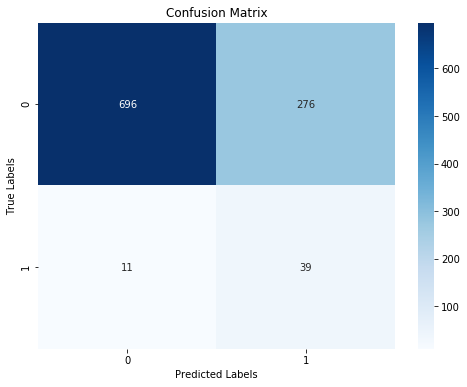

[[696 276]
 [ 11  39]]





In [33]:
# Changing smote k neighbours to 3 as it causes tighter resampling and therefore possibly better results

params = {'smote__k_neighbors': 3, 
          'classifier__subsample': 0.9, 
          'classifier__n_estimators': 300, 
          'classifier__min_samples_split': 10, 
          'classifier__min_samples_leaf': 1, 
          'classifier__max_depth': 3, 
          'classifier__learning_rate': 0.01}

# Set the pipeline with these parameters
gb_pipeline.set_params(**params)
gb_pipeline.fit(X_train, y_train)

# Predict and generate confusion matrix
predictions = gb_pipeline.predict(X_test)

print(f"Parameters: {params}")

# evaluate the predictions
accuracy = accuracy_score(y_test, predictions)
print(f"Model Accuracy: {accuracy}")
print(classification_report(y_test, predictions))
print("\n\n")

conf_matrix = confusion_matrix(y_test, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

print(conf_matrix)

print(f"\n\n")

Parameters: {'smote__k_neighbors': 3, 'classifier__subsample': 0.9, 'classifier__n_estimators': 300, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 50, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.01}
Model Accuracy: 0.6966731898238747
              precision    recall  f1-score   support

           0       0.99      0.69      0.81       972
           1       0.12      0.82      0.21        50

    accuracy                           0.70      1022
   macro avg       0.55      0.76      0.51      1022
weighted avg       0.94      0.70      0.78      1022






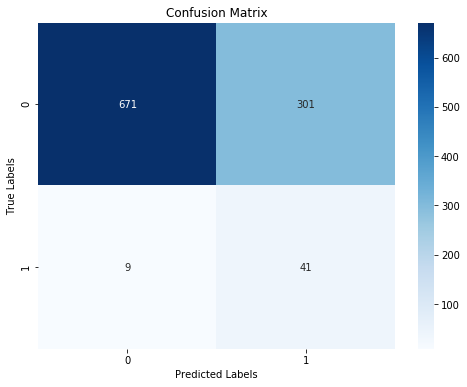

[[671 301]
 [  9  41]]





In [38]:
# Changing min sample leaf to 50 to increase the minimum size before forming a leaf

params = {'smote__k_neighbors': 3, 
          'classifier__subsample': 0.9, 
          'classifier__n_estimators': 300, 
          'classifier__min_samples_split': 10, 
          'classifier__min_samples_leaf': 50, 
          'classifier__max_depth': 3, 
          'classifier__learning_rate': 0.01}

# Set the pipeline with these parameters
gb_pipeline.set_params(**params)
gb_pipeline.fit(X_train, y_train)

# Predict and generate confusion matrix
predictions = gb_pipeline.predict(X_test)

print(f"Parameters: {params}")

# evaluate the predictions
accuracy = accuracy_score(y_test, predictions)
print(f"Model Accuracy: {accuracy}")
print(classification_report(y_test, predictions))
print("\n\n")

conf_matrix = confusion_matrix(y_test, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

print(conf_matrix)

print(f"\n\n")

Parameters: {'smote__k_neighbors': 3, 'classifier__subsample': 0.9, 'classifier__n_estimators': 100, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 50, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.01}
Model Accuracy: 0.6722113502935421
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       972
           1       0.11      0.84      0.20        50

    accuracy                           0.67      1022
   macro avg       0.55      0.75      0.50      1022
weighted avg       0.94      0.67      0.76      1022






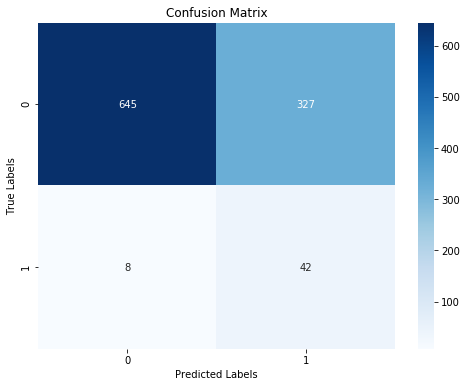

[[645 327]
 [  8  42]]





In [44]:
# decreasing estimators, the learning rate is low but the data is not a large dataset

params = {'smote__k_neighbors': 3, 
          'classifier__subsample': 0.9, 
          'classifier__n_estimators': 100, 
          'classifier__min_samples_split': 10, 
          'classifier__min_samples_leaf': 50, 
          'classifier__max_depth': 3, 
          'classifier__learning_rate': 0.01}

# Set the pipeline with these parameters
gb_pipeline.set_params(**params)
gb_pipeline.fit(X_train, y_train)

# Predict and generate confusion matrix
predictions = gb_pipeline.predict(X_test)

print(f"Parameters: {params}")

# evaluate the predictions
accuracy = accuracy_score(y_test, predictions)
print(f"Model Accuracy: {accuracy}")
print(classification_report(y_test, predictions))
print("\n\n")

conf_matrix = confusion_matrix(y_test, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

print(conf_matrix)

print(f"\n\n")

Parameters: {'smote__k_neighbors': 3, 'classifier__subsample': 1.0, 'classifier__n_estimators': 100, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 50, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.01}
Model Accuracy: 0.6741682974559687
              precision    recall  f1-score   support

           0       0.99      0.67      0.80       972
           1       0.11      0.82      0.20        50

    accuracy                           0.67      1022
   macro avg       0.55      0.74      0.50      1022
weighted avg       0.94      0.67      0.77      1022






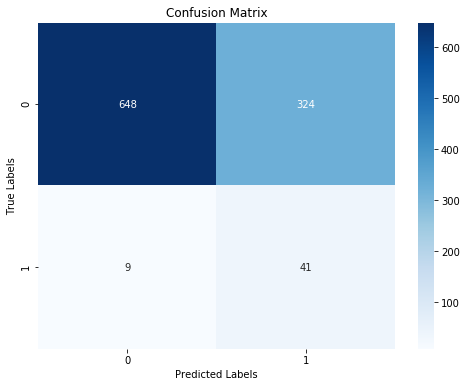

[[648 324]
 [  9  41]]





In [47]:
# Resample the whole dataset each time - did not work

params = {'smote__k_neighbors': 3, 
          'classifier__subsample': 1.0, 
          'classifier__n_estimators': 100, 
          'classifier__min_samples_split': 10, 
          'classifier__min_samples_leaf': 50, 
          'classifier__max_depth': 3, 
          'classifier__learning_rate': 0.01}

# Set the pipeline with these parameters
gb_pipeline.set_params(**params)
gb_pipeline.fit(X_train, y_train)

# Predict and generate confusion matrix
predictions = gb_pipeline.predict(X_test)

print(f"Parameters: {params}")

# evaluate the predictions
accuracy = accuracy_score(y_test, predictions)
print(f"Model Accuracy: {accuracy}")
print(classification_report(y_test, predictions))
print("\n\n")

conf_matrix = confusion_matrix(y_test, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

print(conf_matrix)

print(f"\n\n")

Parameters: {'smote__k_neighbors': 3, 'classifier__subsample': 0.9, 'classifier__n_estimators': 100, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 50, 'classifier__max_depth': 5, 'classifier__learning_rate': 0.01}
Model Accuracy: 0.7318982387475538
              precision    recall  f1-score   support

           0       0.99      0.73      0.84       972
           1       0.13      0.80      0.23        50

    accuracy                           0.73      1022
   macro avg       0.56      0.76      0.53      1022
weighted avg       0.94      0.73      0.81      1022






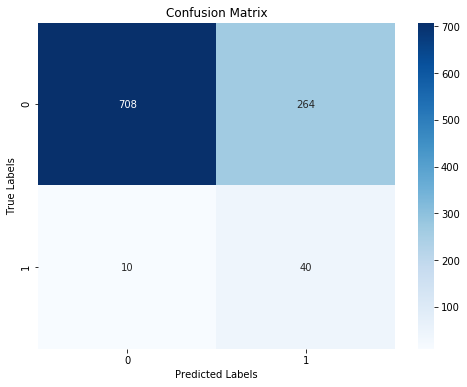

[[708 264]
 [ 10  40]]





In [51]:
# Increase max depth of the tree to 5 to try and limit overfitting to class 1 label

params = {'smote__k_neighbors': 3, 
          'classifier__subsample': 0.9, 
          'classifier__n_estimators': 100, 
          'classifier__min_samples_split': 10, 
          'classifier__min_samples_leaf': 50, 
          'classifier__max_depth': 5, 
          'classifier__learning_rate': 0.01}

# Set the pipeline with these parameters
gb_pipeline.set_params(**params)
gb_pipeline.fit(X_train, y_train)

# Predict and generate confusion matrix
predictions = gb_pipeline.predict(X_test)

print(f"Parameters: {params}")

# evaluate the predictions
accuracy = accuracy_score(y_test, predictions)
print(f"Model Accuracy: {accuracy}")
print(classification_report(y_test, predictions))
print("\n\n")

conf_matrix = confusion_matrix(y_test, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

print(conf_matrix)

print(f"\n\n")

### Gradient Boosted Classifier Summary

After establishing the baseline and transformation model results, a search was conducted on the model across various parameters. The original search parameters were:

param_dist = {
    'classifier__n_estimators': [100, 200, 300, 400, 500],
    'classifier__max_depth': [3, 4, 5, 6, 7, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__learning_rate': [0.01, 0.1, 0.2, 0.5],
    'classifier__subsample': [0.8, 0.9, 1.0],
    'smote__k_neighbors': [1, 2, 3, 5, 10] 
}

The results from the random search with 10 fold cross validation were good, but did not meet the threshold of 80% recall for class 1, therefore, not in an acceptable range for the model (read above summary).

The choice was made to widen the parameters of the search and assess if that produced a set of better performing parameters for the model. The widened perameters were:

param_dist_expanded = {
    'classifier__n_estimators': [100, 200, 300, 400, 500, 600, 700],
    'classifier__learning_rate': [0.005, 0.01, 0.05, 0.1, 0.2],
    'classifier__max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'classifier__min_samples_split': [2, 5, 10, 15, 20],
    'classifier__min_samples_leaf': [1, 2, 4, 6, 8],
    'classifier__subsample': [0.7, 0.8, 0.9, 1.0],
    'classifier__max_features': ['sqrt', 'log2', None, 0.7, 0.8, 0.9],
    'smote__k_neighbors': [5, 10, 15, 20, 25, 30]
}

As there was no set of model parameters which breached the threshold of 80% recall for class 1 events, the decision was made to take the best performing parameters across both searches, and manually adjust the parameters to assess if the model could cross the threshold.

Original Random Search Finding:

params: {'smote__k_neighbors': 10, 'classifier__subsample': 0.9, 'classifier__n_estimators': 300, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 1, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.01}

recall class 1: 75%
recall class 0: 75%

Changes to the k_neighbors parameter:

Parameters: {'smote__k_neighbors': 3, 'classifier__subsample': 0.9, 'classifier__n_estimators': 100, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 50, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.01}

recall class 1: 84%
recall class 0: 66%

The result is close to the random forest result. The high number of false positives is maintained, with a slightly higher nummber of false negatives. Considering the computation cost of gradient boosting and its inability to provide significantly better predictions than the random forest result, it would not be an effective model to implement in place of the random forest.

# Support Vector Machines

As the dataset is small and the problem is binary classification, a Support Vector Machine (SVM) is a very promising model to use. SVMs are very powerful models for a number of machine learning problems. SVMs are however sensitive to scaling in features and therefore rely on good data preparation in order for them to perform well.

In order to prepare data for a baseline model it will require the following steps:

1. Split the data
2. Handle missing values with the BMI imputer
3. Encode categorical features
4. Scale the numerical data

The data transformations applied earlier, and feature engineering will be used in a next step after a baseline is established.

To start with, a linear SVC will be used.



In [28]:
from sklearn.svm import SVC

In [65]:
# reproduce the split of data
# Prepare data for modelling with the new features

# Declare the feature and target datasets
X = df.drop(['id', 'stroke'], axis=1)
y = df['stroke'].values

# split the data using the exact same split we assessed before - hence the random seed being set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42, stratify=y)

In [40]:
# Handle missing values for bmi
imputer = SimpleImputer(strategy="median")
X_train['bmi'] = imputer.fit_transform(X_train[['bmi']])

# Define numerical and categorical columns
num_attribs = ['age', 'avg_glucose_level', 'bmi']
cat_attribs = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

# Create a pipeline for numerical attributes
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler()),
])

# initiate linear SVC
svm_clf = SVC(kernel='linear')

# Combine numerical and categorical transformations
preprocess_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs)
])



In [43]:
X_train_scaled = preprocess_pipeline.fit_transform(X_train)

In [44]:
svm_clf.fit(X_train_scaled, y_train)

SVC(kernel='linear')

In [45]:
X_test_scaled = preprocess_pipeline.transform(X_test)


In [46]:
predictions = svm_clf.predict(X_test_scaled)

Model Accuracy: 0.9510763209393346
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.00      0.00      0.00        50

    accuracy                           0.95      1022
   macro avg       0.48      0.50      0.49      1022
weighted avg       0.90      0.95      0.93      1022






/home/up842192/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/up842192/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/up842192/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


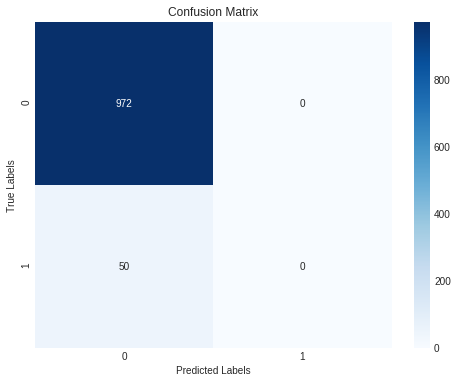

[[972   0]
 [ 50   0]]





In [47]:
# evaluate the predictions
accuracy = accuracy_score(y_test, predictions)
print(f"Model Accuracy: {accuracy}")
print(classification_report(y_test, predictions))
print("\n\n")

conf_matrix = confusion_matrix(y_test, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

print(conf_matrix)

print(f"\n\n")

The linear classifier does not work with this dataset at all. The next step is to change the kernel in the model to the Radial Basis Function (RBF). The RBF transforms data into a higher-dimensional space using a Gaussian-like transformation. A class weight parameter will also be introduced to allow the misbalanced data to be modelled.

In [53]:
# initiate rbf SVC
svm_rbf_clf = SVC(kernel='rbf', class_weight='balanced')

In [54]:
svm_rbf_clf.fit(X_train_scaled, y_train)

predictions = svm_rbf_clf.predict(X_test_scaled)

Model Accuracy: 0.7407045009784736
              precision    recall  f1-score   support

           0       0.98      0.74      0.84       972
           1       0.13      0.72      0.21        50

    accuracy                           0.74      1022
   macro avg       0.55      0.73      0.53      1022
weighted avg       0.94      0.74      0.81      1022






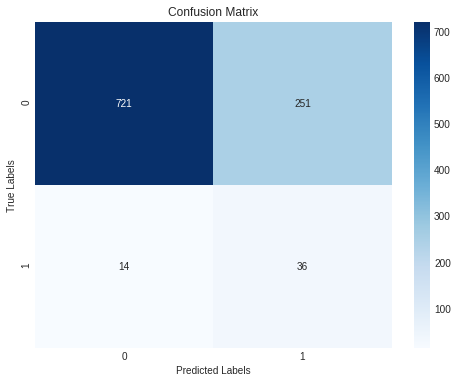

[[721 251]
 [ 14  36]]





In [55]:
# evaluate the predictions
accuracy = accuracy_score(y_test, predictions)
print(f"Model Accuracy: {accuracy}")
print(classification_report(y_test, predictions))
print("\n\n")

conf_matrix = confusion_matrix(y_test, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

print(conf_matrix)

print(f"\n\n")

vast improvement when changing the kernel.

In [62]:
# instantiate smote
smote = SMOTE(k_neighbors=3, random_state=42)

# initiate rbf SVC
svm_rbf_clf = SVC(kernel='rbf', class_weight='balanced')

svm_rbf_pipeline = ImbPipeline(steps=[
    ('preprocessor', CustomPreprocessor()),             # custom preprocessing and feature engineering
    ('smote', smote),                         # SMOTE for handling class imbalance
    ('classifier', svm_rbf_clf)    # Random Forest classifier
])

In [66]:
svm_rbf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor', CustomPreprocessor()),
                ('smote', SMOTE(k_neighbors=3, random_state=42)),
                ('classifier', SVC(class_weight='balanced'))])

In [68]:
predictions = svm_rbf_pipeline.predict(X_test)

Model Accuracy: 0.7093933463796478
              precision    recall  f1-score   support

           0       0.98      0.71      0.82       972
           1       0.12      0.78      0.21        50

    accuracy                           0.71      1022
   macro avg       0.55      0.74      0.52      1022
weighted avg       0.94      0.71      0.79      1022






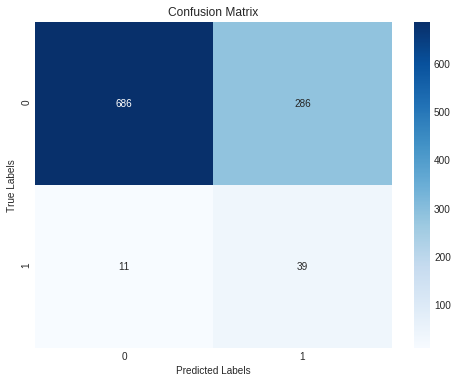

[[686 286]
 [ 11  39]]





In [69]:
# evaluate the predictions
accuracy = accuracy_score(y_test, predictions)
print(f"Model Accuracy: {accuracy}")
print(classification_report(y_test, predictions))
print("\n\n")

conf_matrix = confusion_matrix(y_test, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

print(conf_matrix)

print(f"\n\n")

### Random Forest vs Gradient Boosted vs SVM Classifier Results After Transformation

#### Random Forest

- Accuracy 69.18%

- Class 0 Precision 98%
- Class 0 Recall 69%
- Class 0 F1-Score 81%

- Class 1 Precision 11%
- Class 1 Recall 78%
- Class 1 F1-Score 20%

#### Confusion Matrix
The confusion matrix [668, 304], [11, 39] can be interpreted as follows:

- True Negative (TN = 772): The model correctly predicted the negative class (class 0) 772 times.
- False Positive (FP = 304): The model incorrectly predicted the positive class (class 1) 304 times when it was actually class 0.
- False Negative (FN = 11): The model incorrectly predicted the negative class 11 times when it was actually class 1.
- True Positive (TP = 39): The model correctly predicted the positive class only 39 times.

#### Gradient Boosted Classifier

- Accuracy 70.48%

- Class 0 Precision 98%
- Class 0 Recall 74%
- Class 0 F1-Score 84%

- Class 1 Precision 12%
- Class 1 Recall 70%
- Class 1 F1-Score 21%

#### Confusion Matrix
The confusion matrix [716, 256], [15, 35] can be interpreted as follows:

- True Negative (TN = 716): The model correctly predicted the negative class (class 0) 716 times.
- False Positive (FP = 256): The model incorrectly predicted the positive class (class 1) 256 times when it was actually class 0.
- False Negative (FN = 15): The model incorrectly predicted the negative class 15 times when it was actually class 1.
- True Positive (TP = 35): The model correctly predicted the positive class only 35 times.

#### SVM Classifier

- Accuracy 73.94%

- Class 0 Precision 98%
- Class 0 Recall 71%
- Class 0 F1-Score 82%

- Class 1 Precision 12%
- Class 1 Recall 78%
- Class 1 F1-Score 21%

#### Confusion Matrix
The confusion matrix [686, 286], [11, 39] can be interpreted as follows:

- True Negative (TN = 686): The model correctly predicted the negative class (class 0) 686 times.
- False Positive (FP = 286): The model incorrectly predicted the positive class (class 1) 286 times when it was actually class 0.
- False Negative (FN = 11): The model incorrectly predicted the negative class 11 times when it was actually class 1.
- True Positive (TP = 39): The model correctly predicted the positive class only 39 times.


#### Summary

After the transformations and feature engineering the model performs slightly better than both the random forest and the gradient boosted classifier from a near default configuration. The false positives are between the random forest level and the gradient boosting level, which is acceptable for the model while the false negatives are as low as the random forest and lower than the gradient boosting classifier.

The next steps are to parameter tune and cross validate.

In [79]:
full_pipeline = ImbPipeline(steps=[
    ('preprocessor', CustomPreprocessor()),             # custom preprocessing and feature engineering
    ('smote', SMOTE()),                         # SMOTE for handling class imbalance
    ('classifier', SVC(kernel='rbf', class_weight='balanced'))    # SVM Classifier
])

In [80]:
from scipy.stats import expon, reciprocal

# Set parameters
params = {
    'classifier__C': reciprocal(0.001, 1000),
    'classifier__kernel': ['rbf', 'poly', 'sigmoid'],
    'classifier__gamma': expon(scale=1.0),
    'classifier__degree': [2, 3, 4, 5],
    'classifier__coef0': [0.0, 1.0, 5.0, 10.0],
    # SMOTE parameters
    'smote__k_neighbors': [1, 2, 3, 5, 10]
    }


f1_scorer_macro = make_scorer(f1_score, average='binary')
svc_random_search = RandomizedSearchCV(full_pipeline, param_distributions=params,
                                   n_iter=100, cv=5, scoring=f1_scorer_macro,
                                   verbose=2, random_state=42)

In [81]:
svc_random_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END classifier__C=0.17670169402947947, classifier__coef0=0.0, classifier__degree=4, classifier__gamma=1.3167456935454493, classifier__kernel=rbf, smote__k_neighbors=10; total time=   5.7s
[CV] END classifier__C=0.17670169402947947, classifier__coef0=0.0, classifier__degree=4, classifier__gamma=1.3167456935454493, classifier__kernel=rbf, smote__k_neighbors=10; total time=   4.1s
[CV] END classifier__C=0.17670169402947947, classifier__coef0=0.0, classifier__degree=4, classifier__gamma=1.3167456935454493, classifier__kernel=rbf, smote__k_neighbors=10; total time=   4.2s
[CV] END classifier__C=0.17670169402947947, classifier__coef0=0.0, classifier__degree=4, classifier__gamma=1.3167456935454493, classifier__kernel=rbf, smote__k_neighbors=10; total time=   4.1s
[CV] END classifier__C=0.17670169402947947, classifier__coef0=0.0, classifier__degree=4, classifier__gamma=1.3167456935454493, classifier__kernel=rbf, smote__k_neigh

[CV] END classifier__C=2.3973382079286485, classifier__coef0=1.0, classifier__degree=2, classifier__gamma=0.0160950859938234, classifier__kernel=poly, smote__k_neighbors=5; total time=   1.8s
[CV] END classifier__C=2.3973382079286485, classifier__coef0=1.0, classifier__degree=2, classifier__gamma=0.0160950859938234, classifier__kernel=poly, smote__k_neighbors=5; total time=   1.7s
[CV] END classifier__C=0.027935265040422538, classifier__coef0=10.0, classifier__degree=4, classifier__gamma=0.9415999701070139, classifier__kernel=sigmoid, smote__k_neighbors=3; total time=   5.6s
[CV] END classifier__C=0.027935265040422538, classifier__coef0=10.0, classifier__degree=4, classifier__gamma=0.9415999701070139, classifier__kernel=sigmoid, smote__k_neighbors=3; total time=   5.6s
[CV] END classifier__C=0.027935265040422538, classifier__coef0=10.0, classifier__degree=4, classifier__gamma=0.9415999701070139, classifier__kernel=sigmoid, smote__k_neighbors=3; total time=   5.7s
[CV] END classifier__C

[CV] END classifier__C=55.087522789910395, classifier__coef0=5.0, classifier__degree=2, classifier__gamma=2.607764399984743, classifier__kernel=poly, smote__k_neighbors=1; total time=20.9min
[CV] END classifier__C=55.087522789910395, classifier__coef0=5.0, classifier__degree=2, classifier__gamma=2.607764399984743, classifier__kernel=poly, smote__k_neighbors=1; total time=13.8min
[CV] END classifier__C=55.087522789910395, classifier__coef0=5.0, classifier__degree=2, classifier__gamma=2.607764399984743, classifier__kernel=poly, smote__k_neighbors=1; total time=12.8min
[CV] END classifier__C=55.087522789910395, classifier__coef0=5.0, classifier__degree=2, classifier__gamma=2.607764399984743, classifier__kernel=poly, smote__k_neighbors=1; total time=10.9min
[CV] END classifier__C=308.85742992785015, classifier__coef0=0.0, classifier__degree=5, classifier__gamma=0.5968387249046296, classifier__kernel=rbf, smote__k_neighbors=10; total time=   1.4s
[CV] END classifier__C=308.85742992785015, c

[CV] END classifier__C=0.004295023644269913, classifier__coef0=10.0, classifier__degree=5, classifier__gamma=0.24646391605155396, classifier__kernel=poly, smote__k_neighbors=3; total time=   2.7s
[CV] END classifier__C=0.08832225038629851, classifier__coef0=5.0, classifier__degree=5, classifier__gamma=0.4405191413413164, classifier__kernel=poly, smote__k_neighbors=1; total time=   2.2s
[CV] END classifier__C=0.08832225038629851, classifier__coef0=5.0, classifier__degree=5, classifier__gamma=0.4405191413413164, classifier__kernel=poly, smote__k_neighbors=1; total time=   2.0s
[CV] END classifier__C=0.08832225038629851, classifier__coef0=5.0, classifier__degree=5, classifier__gamma=0.4405191413413164, classifier__kernel=poly, smote__k_neighbors=1; total time=   1.6s
[CV] END classifier__C=0.08832225038629851, classifier__coef0=5.0, classifier__degree=5, classifier__gamma=0.4405191413413164, classifier__kernel=poly, smote__k_neighbors=1; total time=   1.7s
[CV] END classifier__C=0.0883222

[CV] END classifier__C=0.0030557650401968747, classifier__coef0=10.0, classifier__degree=4, classifier__gamma=0.27728291596947163, classifier__kernel=poly, smote__k_neighbors=10; total time=   1.7s
[CV] END classifier__C=0.0030557650401968747, classifier__coef0=10.0, classifier__degree=4, classifier__gamma=0.27728291596947163, classifier__kernel=poly, smote__k_neighbors=10; total time=   1.8s
[CV] END classifier__C=0.0030557650401968747, classifier__coef0=10.0, classifier__degree=4, classifier__gamma=0.27728291596947163, classifier__kernel=poly, smote__k_neighbors=10; total time=   1.7s
[CV] END classifier__C=6.220638781359822, classifier__coef0=1.0, classifier__degree=3, classifier__gamma=0.7673852499523488, classifier__kernel=rbf, smote__k_neighbors=1; total time=   2.1s
[CV] END classifier__C=6.220638781359822, classifier__coef0=1.0, classifier__degree=3, classifier__gamma=0.7673852499523488, classifier__kernel=rbf, smote__k_neighbors=1; total time=   2.2s
[CV] END classifier__C=6.2

[CV] END classifier__C=137.38703509603747, classifier__coef0=1.0, classifier__degree=5, classifier__gamma=2.1872058219415274, classifier__kernel=sigmoid, smote__k_neighbors=1; total time=   3.0s
[CV] END classifier__C=137.38703509603747, classifier__coef0=1.0, classifier__degree=5, classifier__gamma=2.1872058219415274, classifier__kernel=sigmoid, smote__k_neighbors=1; total time=   2.5s
[CV] END classifier__C=137.38703509603747, classifier__coef0=1.0, classifier__degree=5, classifier__gamma=2.1872058219415274, classifier__kernel=sigmoid, smote__k_neighbors=1; total time=   2.5s
[CV] END classifier__C=137.38703509603747, classifier__coef0=1.0, classifier__degree=5, classifier__gamma=2.1872058219415274, classifier__kernel=sigmoid, smote__k_neighbors=1; total time=   2.7s
[CV] END classifier__C=137.38703509603747, classifier__coef0=1.0, classifier__degree=5, classifier__gamma=2.1872058219415274, classifier__kernel=sigmoid, smote__k_neighbors=1; total time=   2.3s
[CV] END classifier__C=0.

[CV] END classifier__C=2.704115236691393, classifier__coef0=10.0, classifier__degree=2, classifier__gamma=0.04458298710548632, classifier__kernel=poly, smote__k_neighbors=10; total time=   2.6s
[CV] END classifier__C=2.704115236691393, classifier__coef0=10.0, classifier__degree=2, classifier__gamma=0.04458298710548632, classifier__kernel=poly, smote__k_neighbors=10; total time=   2.5s
[CV] END classifier__C=0.04757316556710787, classifier__coef0=1.0, classifier__degree=4, classifier__gamma=1.37721083711214, classifier__kernel=rbf, smote__k_neighbors=10; total time=   5.1s
[CV] END classifier__C=0.04757316556710787, classifier__coef0=1.0, classifier__degree=4, classifier__gamma=1.37721083711214, classifier__kernel=rbf, smote__k_neighbors=10; total time=   5.1s
[CV] END classifier__C=0.04757316556710787, classifier__coef0=1.0, classifier__degree=4, classifier__gamma=1.37721083711214, classifier__kernel=rbf, smote__k_neighbors=10; total time=   5.2s
[CV] END classifier__C=0.04757316556710

[CV] END classifier__C=208.7867305989819, classifier__coef0=5.0, classifier__degree=5, classifier__gamma=0.8648015834977011, classifier__kernel=sigmoid, smote__k_neighbors=3; total time=   3.0s
[CV] END classifier__C=208.7867305989819, classifier__coef0=5.0, classifier__degree=5, classifier__gamma=0.8648015834977011, classifier__kernel=sigmoid, smote__k_neighbors=3; total time=   3.0s
[CV] END classifier__C=208.7867305989819, classifier__coef0=5.0, classifier__degree=5, classifier__gamma=0.8648015834977011, classifier__kernel=sigmoid, smote__k_neighbors=3; total time=   2.9s
[CV] END classifier__C=208.7867305989819, classifier__coef0=5.0, classifier__degree=5, classifier__gamma=0.8648015834977011, classifier__kernel=sigmoid, smote__k_neighbors=3; total time=   2.9s
[CV] END classifier__C=0.6217103663128162, classifier__coef0=5.0, classifier__degree=3, classifier__gamma=0.3376306603145225, classifier__kernel=poly, smote__k_neighbors=2; total time=   2.9s
[CV] END classifier__C=0.6217103

[CV] END classifier__C=0.010958873666392683, classifier__coef0=0.0, classifier__degree=4, classifier__gamma=0.2880059891265836, classifier__kernel=poly, smote__k_neighbors=1; total time=   1.4s
[CV] END classifier__C=9.145011591835933, classifier__coef0=0.0, classifier__degree=2, classifier__gamma=3.0981034985563065, classifier__kernel=sigmoid, smote__k_neighbors=10; total time=   2.7s
[CV] END classifier__C=9.145011591835933, classifier__coef0=0.0, classifier__degree=2, classifier__gamma=3.0981034985563065, classifier__kernel=sigmoid, smote__k_neighbors=10; total time=   3.3s
[CV] END classifier__C=9.145011591835933, classifier__coef0=0.0, classifier__degree=2, classifier__gamma=3.0981034985563065, classifier__kernel=sigmoid, smote__k_neighbors=10; total time=   2.6s
[CV] END classifier__C=9.145011591835933, classifier__coef0=0.0, classifier__degree=2, classifier__gamma=3.0981034985563065, classifier__kernel=sigmoid, smote__k_neighbors=10; total time=   2.6s
[CV] END classifier__C=9.1

[CV] END classifier__C=159.65907224792852, classifier__coef0=10.0, classifier__degree=4, classifier__gamma=1.614195686122846, classifier__kernel=poly, smote__k_neighbors=3; total time=   2.2s
[CV] END classifier__C=159.65907224792852, classifier__coef0=10.0, classifier__degree=4, classifier__gamma=1.614195686122846, classifier__kernel=poly, smote__k_neighbors=3; total time=   3.9s
[CV] END classifier__C=159.65907224792852, classifier__coef0=10.0, classifier__degree=4, classifier__gamma=1.614195686122846, classifier__kernel=poly, smote__k_neighbors=3; total time=   2.8s
[CV] END classifier__C=7.239845705114226, classifier__coef0=0.0, classifier__degree=2, classifier__gamma=0.7888143605763202, classifier__kernel=rbf, smote__k_neighbors=5; total time=   2.9s
[CV] END classifier__C=7.239845705114226, classifier__coef0=0.0, classifier__degree=2, classifier__gamma=0.7888143605763202, classifier__kernel=rbf, smote__k_neighbors=5; total time=   2.7s
[CV] END classifier__C=7.239845705114226, cl

[CV] END classifier__C=0.02701351876046588, classifier__coef0=5.0, classifier__degree=2, classifier__gamma=1.3467227881688555, classifier__kernel=sigmoid, smote__k_neighbors=1; total time=   3.0s
[CV] END classifier__C=0.02701351876046588, classifier__coef0=5.0, classifier__degree=2, classifier__gamma=1.3467227881688555, classifier__kernel=sigmoid, smote__k_neighbors=1; total time=   2.8s
[CV] END classifier__C=0.02701351876046588, classifier__coef0=5.0, classifier__degree=2, classifier__gamma=1.3467227881688555, classifier__kernel=sigmoid, smote__k_neighbors=1; total time=   2.9s
[CV] END classifier__C=0.02701351876046588, classifier__coef0=5.0, classifier__degree=2, classifier__gamma=1.3467227881688555, classifier__kernel=sigmoid, smote__k_neighbors=1; total time=   2.9s
[CV] END classifier__C=0.02701351876046588, classifier__coef0=5.0, classifier__degree=2, classifier__gamma=1.3467227881688555, classifier__kernel=sigmoid, smote__k_neighbors=1; total time=   2.9s
[CV] END classifier_

[CV] END classifier__C=13.433217948250562, classifier__coef0=1.0, classifier__degree=5, classifier__gamma=2.016419459586285, classifier__kernel=poly, smote__k_neighbors=10; total time=   1.6s
[CV] END classifier__C=13.433217948250562, classifier__coef0=1.0, classifier__degree=5, classifier__gamma=2.016419459586285, classifier__kernel=poly, smote__k_neighbors=10; total time=   1.3s
[CV] END classifier__C=0.021650030146735354, classifier__coef0=0.0, classifier__degree=3, classifier__gamma=2.224669958786318, classifier__kernel=poly, smote__k_neighbors=10; total time=   2.7s
[CV] END classifier__C=0.021650030146735354, classifier__coef0=0.0, classifier__degree=3, classifier__gamma=2.224669958786318, classifier__kernel=poly, smote__k_neighbors=10; total time=   2.9s
[CV] END classifier__C=0.021650030146735354, classifier__coef0=0.0, classifier__degree=3, classifier__gamma=2.224669958786318, classifier__kernel=poly, smote__k_neighbors=10; total time=   2.7s
[CV] END classifier__C=0.021650030

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              CustomPreprocessor()),
                                             ('smote', SMOTE()),
                                             ('classifier',
                                              SVC(class_weight='balanced'))]),
                   n_iter=100,
                   param_distributions={'classifier__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f72da5d8b38>,
                                        'classifier__coef0': [0.0, 1.0, 5.0,
                                                              10.0],
                                        'classifier__degree': [2, 3, 4, 5],
                                        'classifier__gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f72da5d8278>,
                                        'classifier__kernel': ['rbf', 'poly',
                                               

In [83]:
results = svc_random_search.cv_results_
# Assess top 50 scores
top_scores = sorted(svc_random_search.cv_results_['mean_test_score'], reverse=True)[:50]
top_indices = [list(svc_random_search.cv_results_['mean_test_score']).index(score) for score in top_scores]
top_params = [svc_random_search.cv_results_['params'][i] for i in top_indices]
recall_results = []

for i, params in enumerate(top_params):
    
    # split the data using the exact same split we assessed before - hence the random seed being set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42, stratify=y)
    
    # Set the pipeline with the current parameters
    full_pipeline.set_params(**params)
    
    # Perform cross-validated predictions
    y_pred = cross_val_predict(full_pipeline, X_train, y_train, cv=5, method='predict')
    
    # Calculate recall for class 1
    recall_class1 = recall_score(y_train, y_pred, pos_label=1)
    # Calculate recall for class 0
    recall_class0 = recall_score(y_train, y_pred, pos_label=0)
    
    # Store results
    iteration_result = {
        'rank': results['rank_test_score'][i],
        'parameters': params,
        'mean_test': results['mean_test_score'][i],
        'std_test': results['std_test_score'][i],
        'recall_class1': recall_class1,
        'recall_class0': recall_class0
    }
    recall_results.append(iteration_result)




In [84]:
# Identify the top models for predicting a class 1 event. Threshold requires 80% accuracy of class 1 predictions
top_recall_class1_params = []

for result in recall_results:
    rank = result.get('rank')
    params = result.get('parameters')
    mean_score = result.get('mean_test')
    std_test = result.get('std_test')
    recall_class1 = result.get('recall_class1')
    recall_class0 = result.get('recall_class0')
    
    print(f"rank: {rank}\nparams: {params}\nmean score: {mean_score}\nstd test: {std_test}\nrecall class 1: {recall_class1}\nrecall class 0: {recall_class0}")
    
    if recall_class1 > 0.80:
        top_recall_class1_params.append(params)
        

rank: 88
params: {'classifier__C': 0.0018679434894556311, 'classifier__coef0': 10.0, 'classifier__degree': 2, 'classifier__gamma': 0.4921302917942186, 'classifier__kernel': 'poly', 'smote__k_neighbors': 10}
mean score: 0.060392893411863956
std test: 0.01684136028275095
recall class 1: 0.7788944723618091
recall class 0: 0.717922345075855
rank: 8
params: {'classifier__C': 0.05992955242224196, 'classifier__coef0': 0.0, 'classifier__degree': 2, 'classifier__gamma': 0.01575994483585621, 'classifier__kernel': 'rbf', 'smote__k_neighbors': 1}
mean score: 0.2088290803263876
std test: 0.013409674183186686
recall class 1: 0.7638190954773869
recall class 0: 0.715608125482129
rank: 13
params: {'classifier__C': 0.11059803649658863, 'classifier__coef0': 5.0, 'classifier__degree': 2, 'classifier__gamma': 0.6852533277464147, 'classifier__kernel': 'poly', 'smote__k_neighbors': 10}
mean score: 0.2048714262651799
std test: 0.012495460577002192
recall class 1: 0.39195979899497485
recall class 0: 0.88711751

Parameters: {'classifier__C': 0.08407761618357404, 'classifier__coef0': 1.0, 'classifier__degree': 5, 'classifier__gamma': 0.0416297597943452, 'classifier__kernel': 'sigmoid', 'smote__k_neighbors': 5}
Model Accuracy: 0.7113502935420744
              precision    recall  f1-score   support

           0       0.99      0.70      0.82       972
           1       0.13      0.84      0.22        50

    accuracy                           0.71      1022
   macro avg       0.56      0.77      0.52      1022
weighted avg       0.95      0.71      0.79      1022






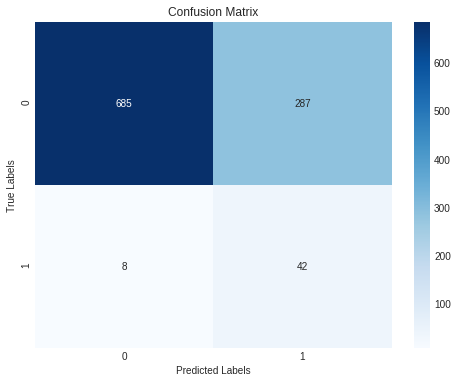

[[685 287]
 [  8  42]]



Parameters: {'classifier__C': 0.008632008168602543, 'classifier__coef0': 5.0, 'classifier__degree': 4, 'classifier__gamma': 0.059838768608680676, 'classifier__kernel': 'rbf', 'smote__k_neighbors': 5}
Model Accuracy: 0.7025440313111546
              precision    recall  f1-score   support

           0       0.99      0.70      0.82       972
           1       0.12      0.80      0.21        50

    accuracy                           0.70      1022
   macro avg       0.55      0.75      0.51      1022
weighted avg       0.94      0.70      0.79      1022






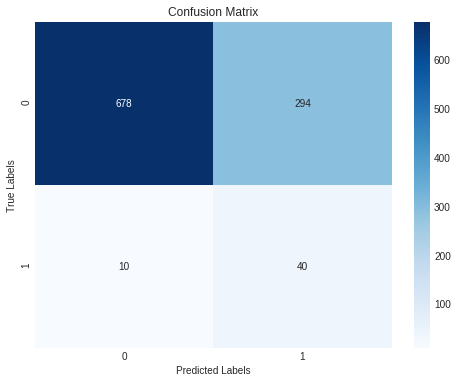

[[678 294]
 [ 10  40]]



Parameters: {'classifier__C': 0.005260025951343322, 'classifier__coef0': 0.0, 'classifier__degree': 3, 'classifier__gamma': 0.0962896317055604, 'classifier__kernel': 'sigmoid', 'smote__k_neighbors': 1}
Model Accuracy: 0.6800391389432485
              precision    recall  f1-score   support

           0       0.99      0.67      0.80       972
           1       0.11      0.82      0.20        50

    accuracy                           0.68      1022
   macro avg       0.55      0.75      0.50      1022
weighted avg       0.94      0.68      0.77      1022






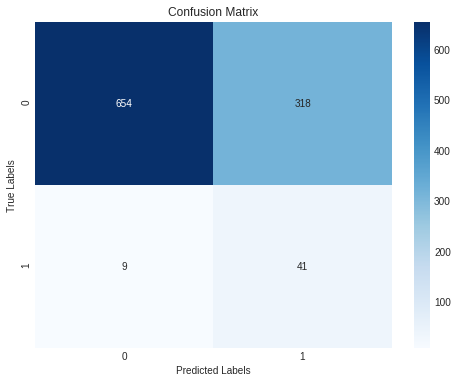

[[654 318]
 [  9  41]]



Parameters: {'classifier__C': 0.04293322340412747, 'classifier__coef0': 5.0, 'classifier__degree': 3, 'classifier__gamma': 0.0005205124384141324, 'classifier__kernel': 'rbf', 'smote__k_neighbors': 1}
Model Accuracy: 0.6663405088062623
              precision    recall  f1-score   support

           0       0.98      0.66      0.79       972
           1       0.11      0.80      0.19        50

    accuracy                           0.67      1022
   macro avg       0.55      0.73      0.49      1022
weighted avg       0.94      0.67      0.76      1022






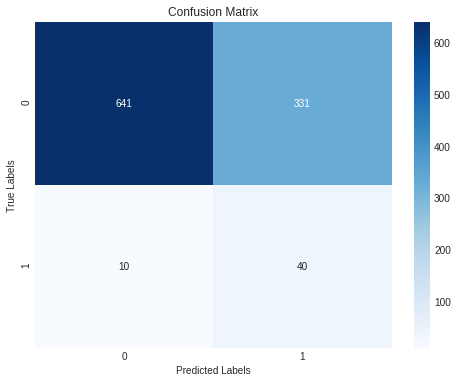

[[641 331]
 [ 10  40]]





In [85]:
# Analyzing top recall parameters
for params in top_recall_class1_params:
    
    # split the data using the exact same split we assessed before - hence the random seed being set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42, stratify=y)
    
    
    # Set the pipeline with these parameters
    full_pipeline.set_params(**params)
    full_pipeline.fit(X_train, y_train)
    
    # Predict and generate confusion matrix
    predictions = full_pipeline.predict(X_test)
    
    print(f"Parameters: {params}")
    
    # evaluate the predictions
    accuracy = accuracy_score(y_test, predictions)
    print(f"Model Accuracy: {accuracy}")
    print(classification_report(y_test, predictions))
    print("\n\n")

    conf_matrix = confusion_matrix(y_test, predictions)

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    print(conf_matrix)
    
    print(f"\n\n")